Importing Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci
import scipy.constants as const
import warnings

Setting Display Options

In [2]:
%config InlineBackend.figure_formats = ['png']

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color = ['olivedrab', 'steelblue', 'firebrick', 'goldenrod'])
mpl.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 600
mpl.rcParams['figure.constrained_layout.use'] = True
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['image.cmap'] = 'magma'

#### Magnetar

In [3]:
def prot_air_cross_sec(Ep):
    a = 280
    b = 8.7
    c = 1.14
    return a - b * np.log(Ep) + c * np.log(Ep)**2

def prot_had_diff_cross_sec(Ep, Eh):
    xE = Eh / Ep
    a = 1.36
    b = 0.42
    c = 3.40
    d = 18.7
    e = 0.43
    f = 0.079
    K = a + b * np.log(np.log(Ep)) + (c + d * Ep**(-e) - f * np.log(Ep)) * xE**(3/2)
    n = 0.51
    return (K + 1) * prot_air_cross_sec(Ep) * (1 + n) * (1 - xE)**n

Toy Air Model Cross Section

$$\begin{align*} \sigma_{pA} = a - b \ln(E) + c \ln^2(E) && E \text{ in GeV} \end{align*}$$

Charm Differential Scattering

$$\begin{align*} \dfrac{d\sigma_{ph}}{dx_E} = \frac{d\sigma_\text{NLO}}{dx_E} + \frac{d\sigma_\text{LO}}{dx_E} && 
\frac{d\sigma_\text{LO}}{dx_E} \equiv \sigma_{pA} (1 + n)(1 − x_E)^n &&
x_E \equiv E_h / E_p \end{align*}$$

Scaling Correction

$$\begin{align*} \dfrac{d\sigma_{ph}}{dx_E} = (K + 1) \frac{d\sigma_\text{LO}}{dx_E} &&
K \equiv \dfrac{d\sigma_\text{LO} / dx_E}{d\sigma_\text{NLO} / dx_E} =
a + b \ln\left( \ln(E) \right) + \left(c + dE^{-e} - f \ln(E)\right)\,x_E^{3/2} \end{align*}$$

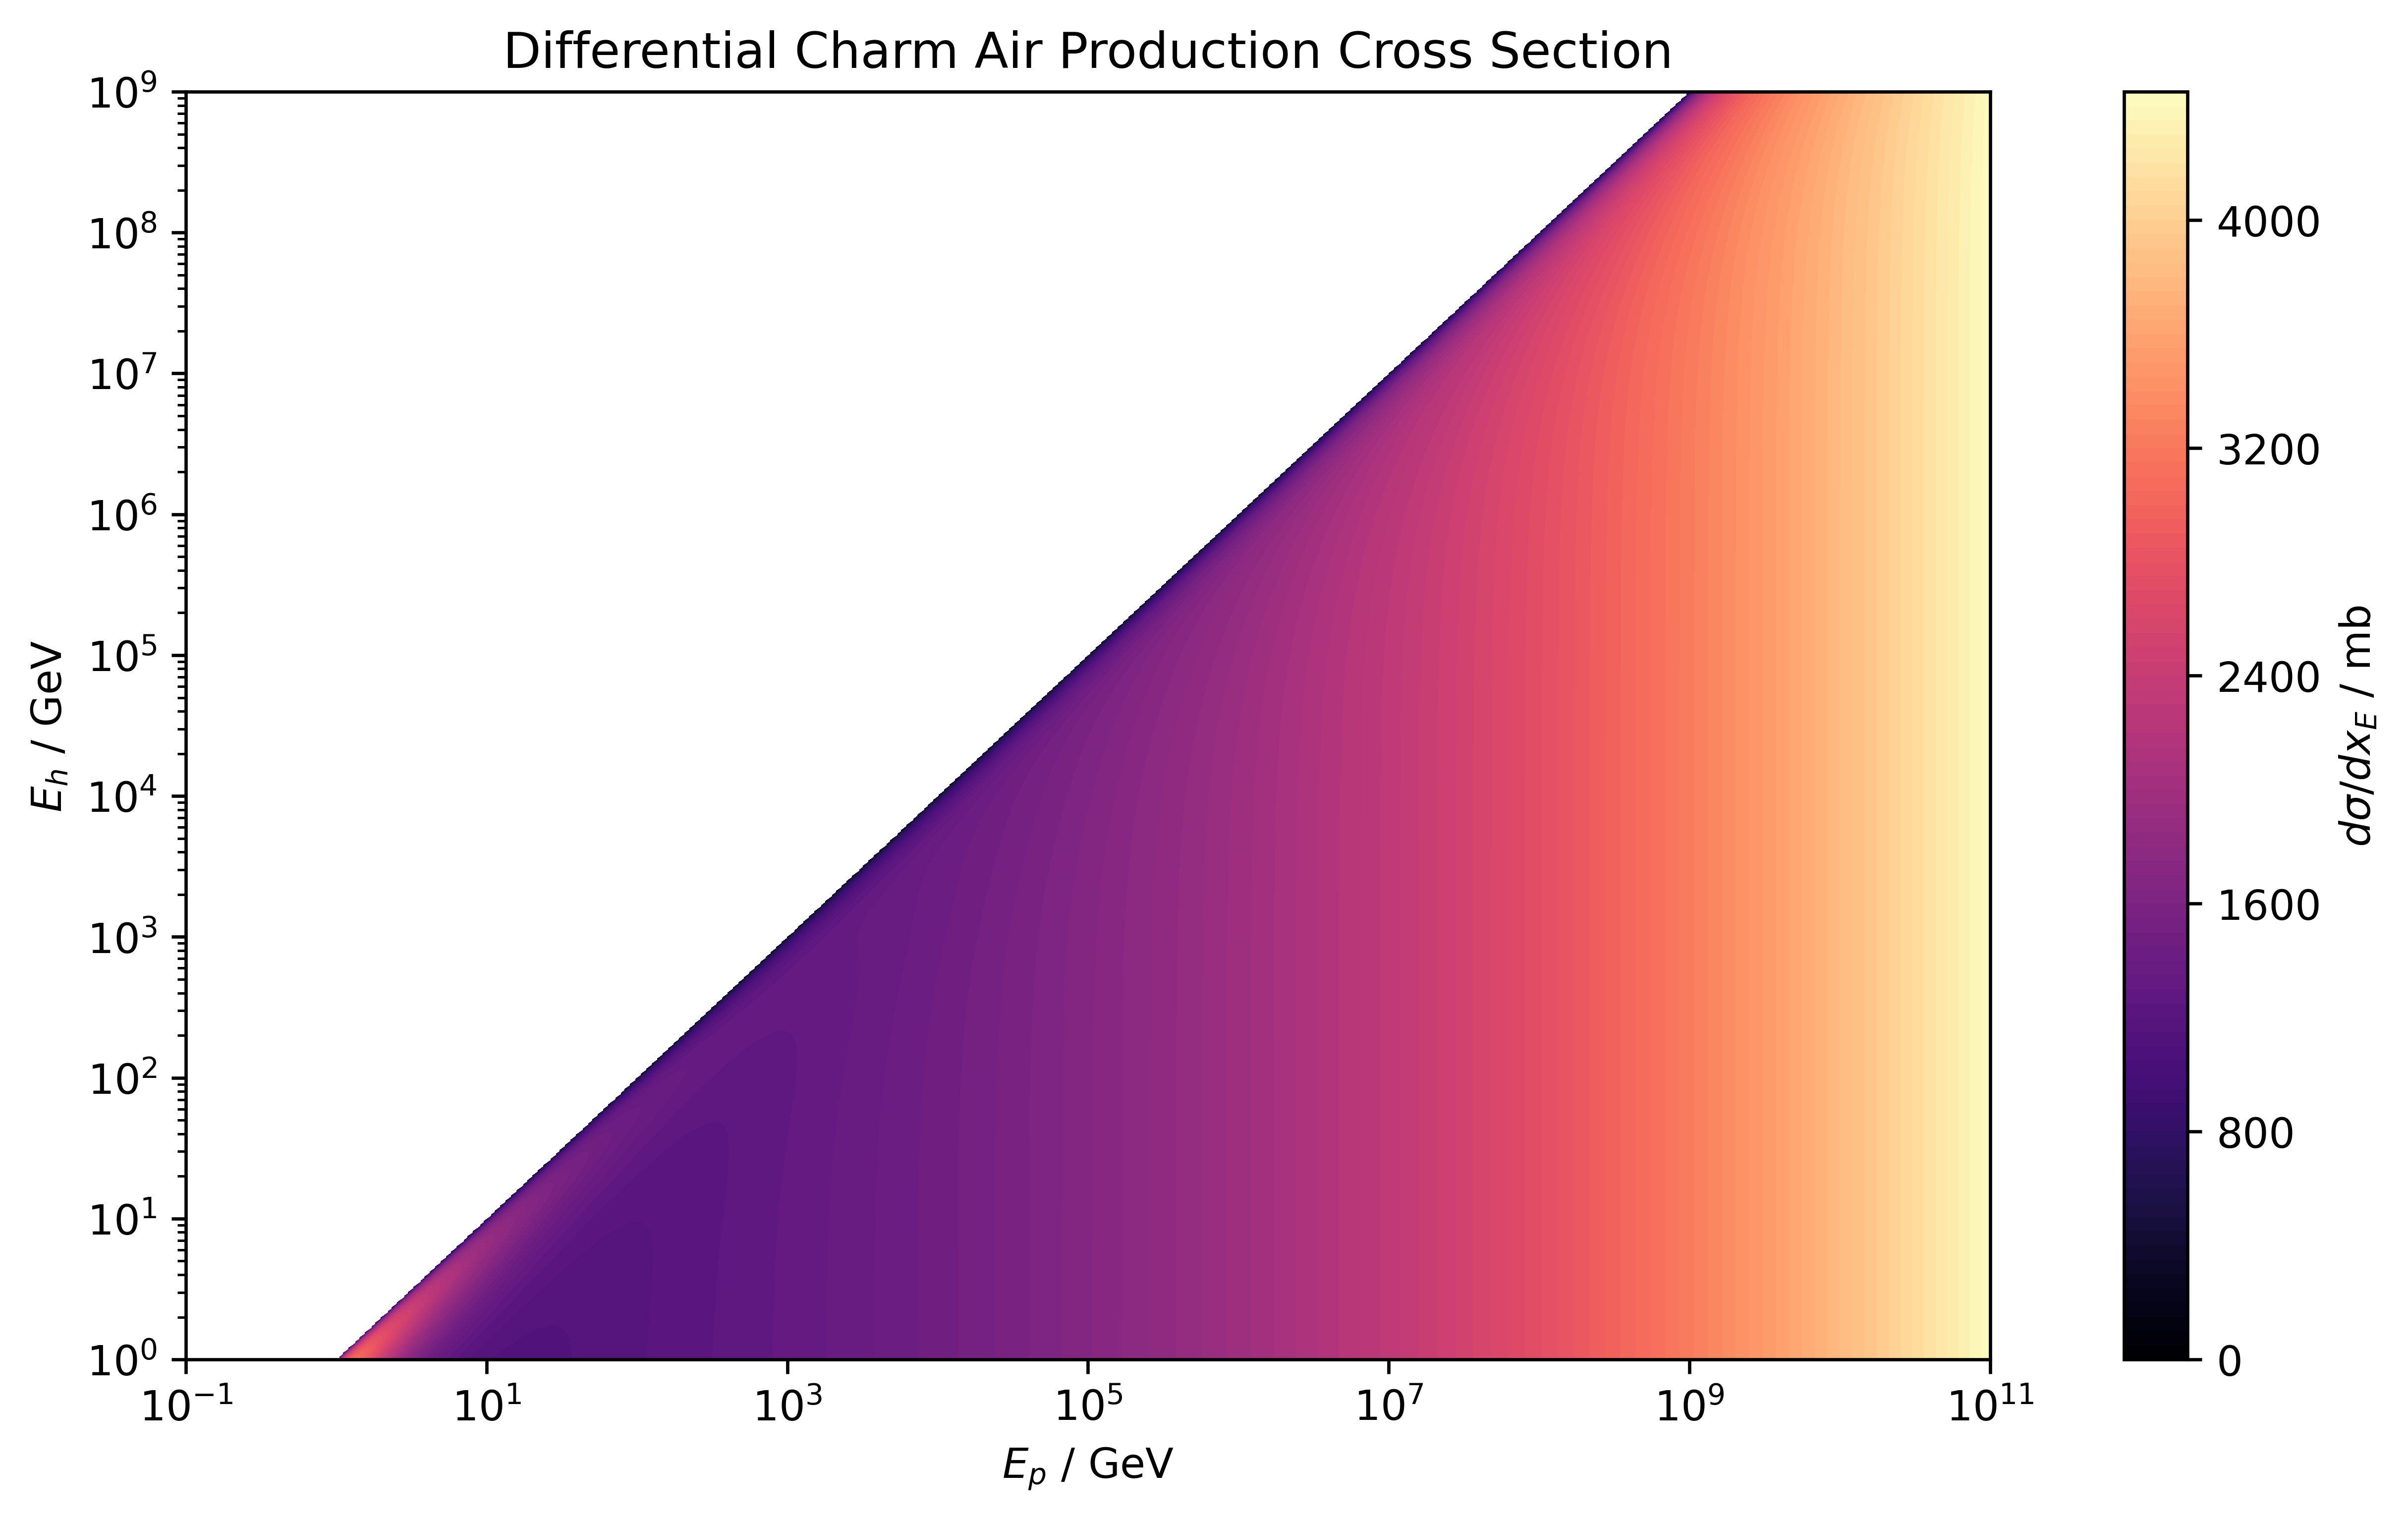

In [4]:
test_Ep = np.logspace(-1, 11, 1000)
test_Eh = np.logspace(0, 9, 1000)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    test_dsig_ph = prot_had_diff_cross_sec(test_Ep[None, :], test_Eh[:, None])

x, y, z = test_Ep, test_Eh, test_dsig_ph
plt.contourf(x, y, z, 100)

plt.colorbar(label=r'$d\sigma/dx_E$ / mb', ticks=np.linspace(0, 4000, 6))

plt.xscale('log')
plt.yscale('log')

plt.title(r'Differential Charm Air Production Cross Section')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$E_h$ / GeV')

plt.show()
plt.close()

In [5]:
def had_spec(t, Eh):
    c = 29979245800
    e = 4.8032047e-10
    I = 10**45
    B = 10**15
    R = 10**6
    Om = 10**4
    chi = 0.3 * np.pi
    facc = 0.1
    tsd = 2 * c**3 * I / (B**2 * R**6 * Om**2 * (1 + np.sin(chi)**2))
    A = facc * e * B * R**3 * Om**2 / (2 * c**2)
    EM = 624.151 * A / (1 + t / tsd)
    C = 2 * c / (facc * e**2)
    return C * prot_had_diff_cross_sec(EM, Eh) / prot_air_cross_sec(EM)

Spindown Time

$$\begin{align*} t_{SD} = \frac{2 c^3 I_{NS}}{B_{NS}^2 R_{NS}^6 \Omega_0^2 (1 + \sin^2 \chi)} \end{align*}$$

Monochromatic Energy

$$\begin{align*} E^M(t) = A (1 + t / t_{SD})^{-1} &&
A \equiv \frac{f_\text{acc} e B_{NS} R_{NS}^3 \Omega_0^2}{2c^2} \end{align*}$$

Proton Spectrum

$$\begin{align*} \frac{d \dot{N}_p}{dE_p} (t, E_p) = B (1 + t / t_{SD})^{-1} \delta(E_p - E^M(t)) &&
B \equiv c^{-1} e^{-1} B_{NS} R_{NS}^3 \Omega_0^2 \end{align*}$$

Singular Interaction

$$\begin{align*} F_{pp \longrightarrow h} (E_h, E_p) = E_p^{-1} \sigma_{pp}^{-1}(E_p) \frac{d\sigma_{ph}}{dx_E}(E_h, E_p)\end{align*}$$

Hadronic Spectrum

$$\begin{align*} \frac{d \dot{N}_h}{dE_h} (t, E_h) = \int_{E_h}^\infty dE_p \frac{d \dot{N}_p}{dE_p} (t, E_p)
F_{pp\longrightarrow h} (E_p, E_h) = C \sigma_{pp}^{-1}(E^M(t)) \frac{d\sigma_{ph}}{dx_E}(E_h, E^M(t)) &&
C \equiv A^{-1}B = 2ce^{-2}f_\text{acc}^{-1} \end{align*}$$

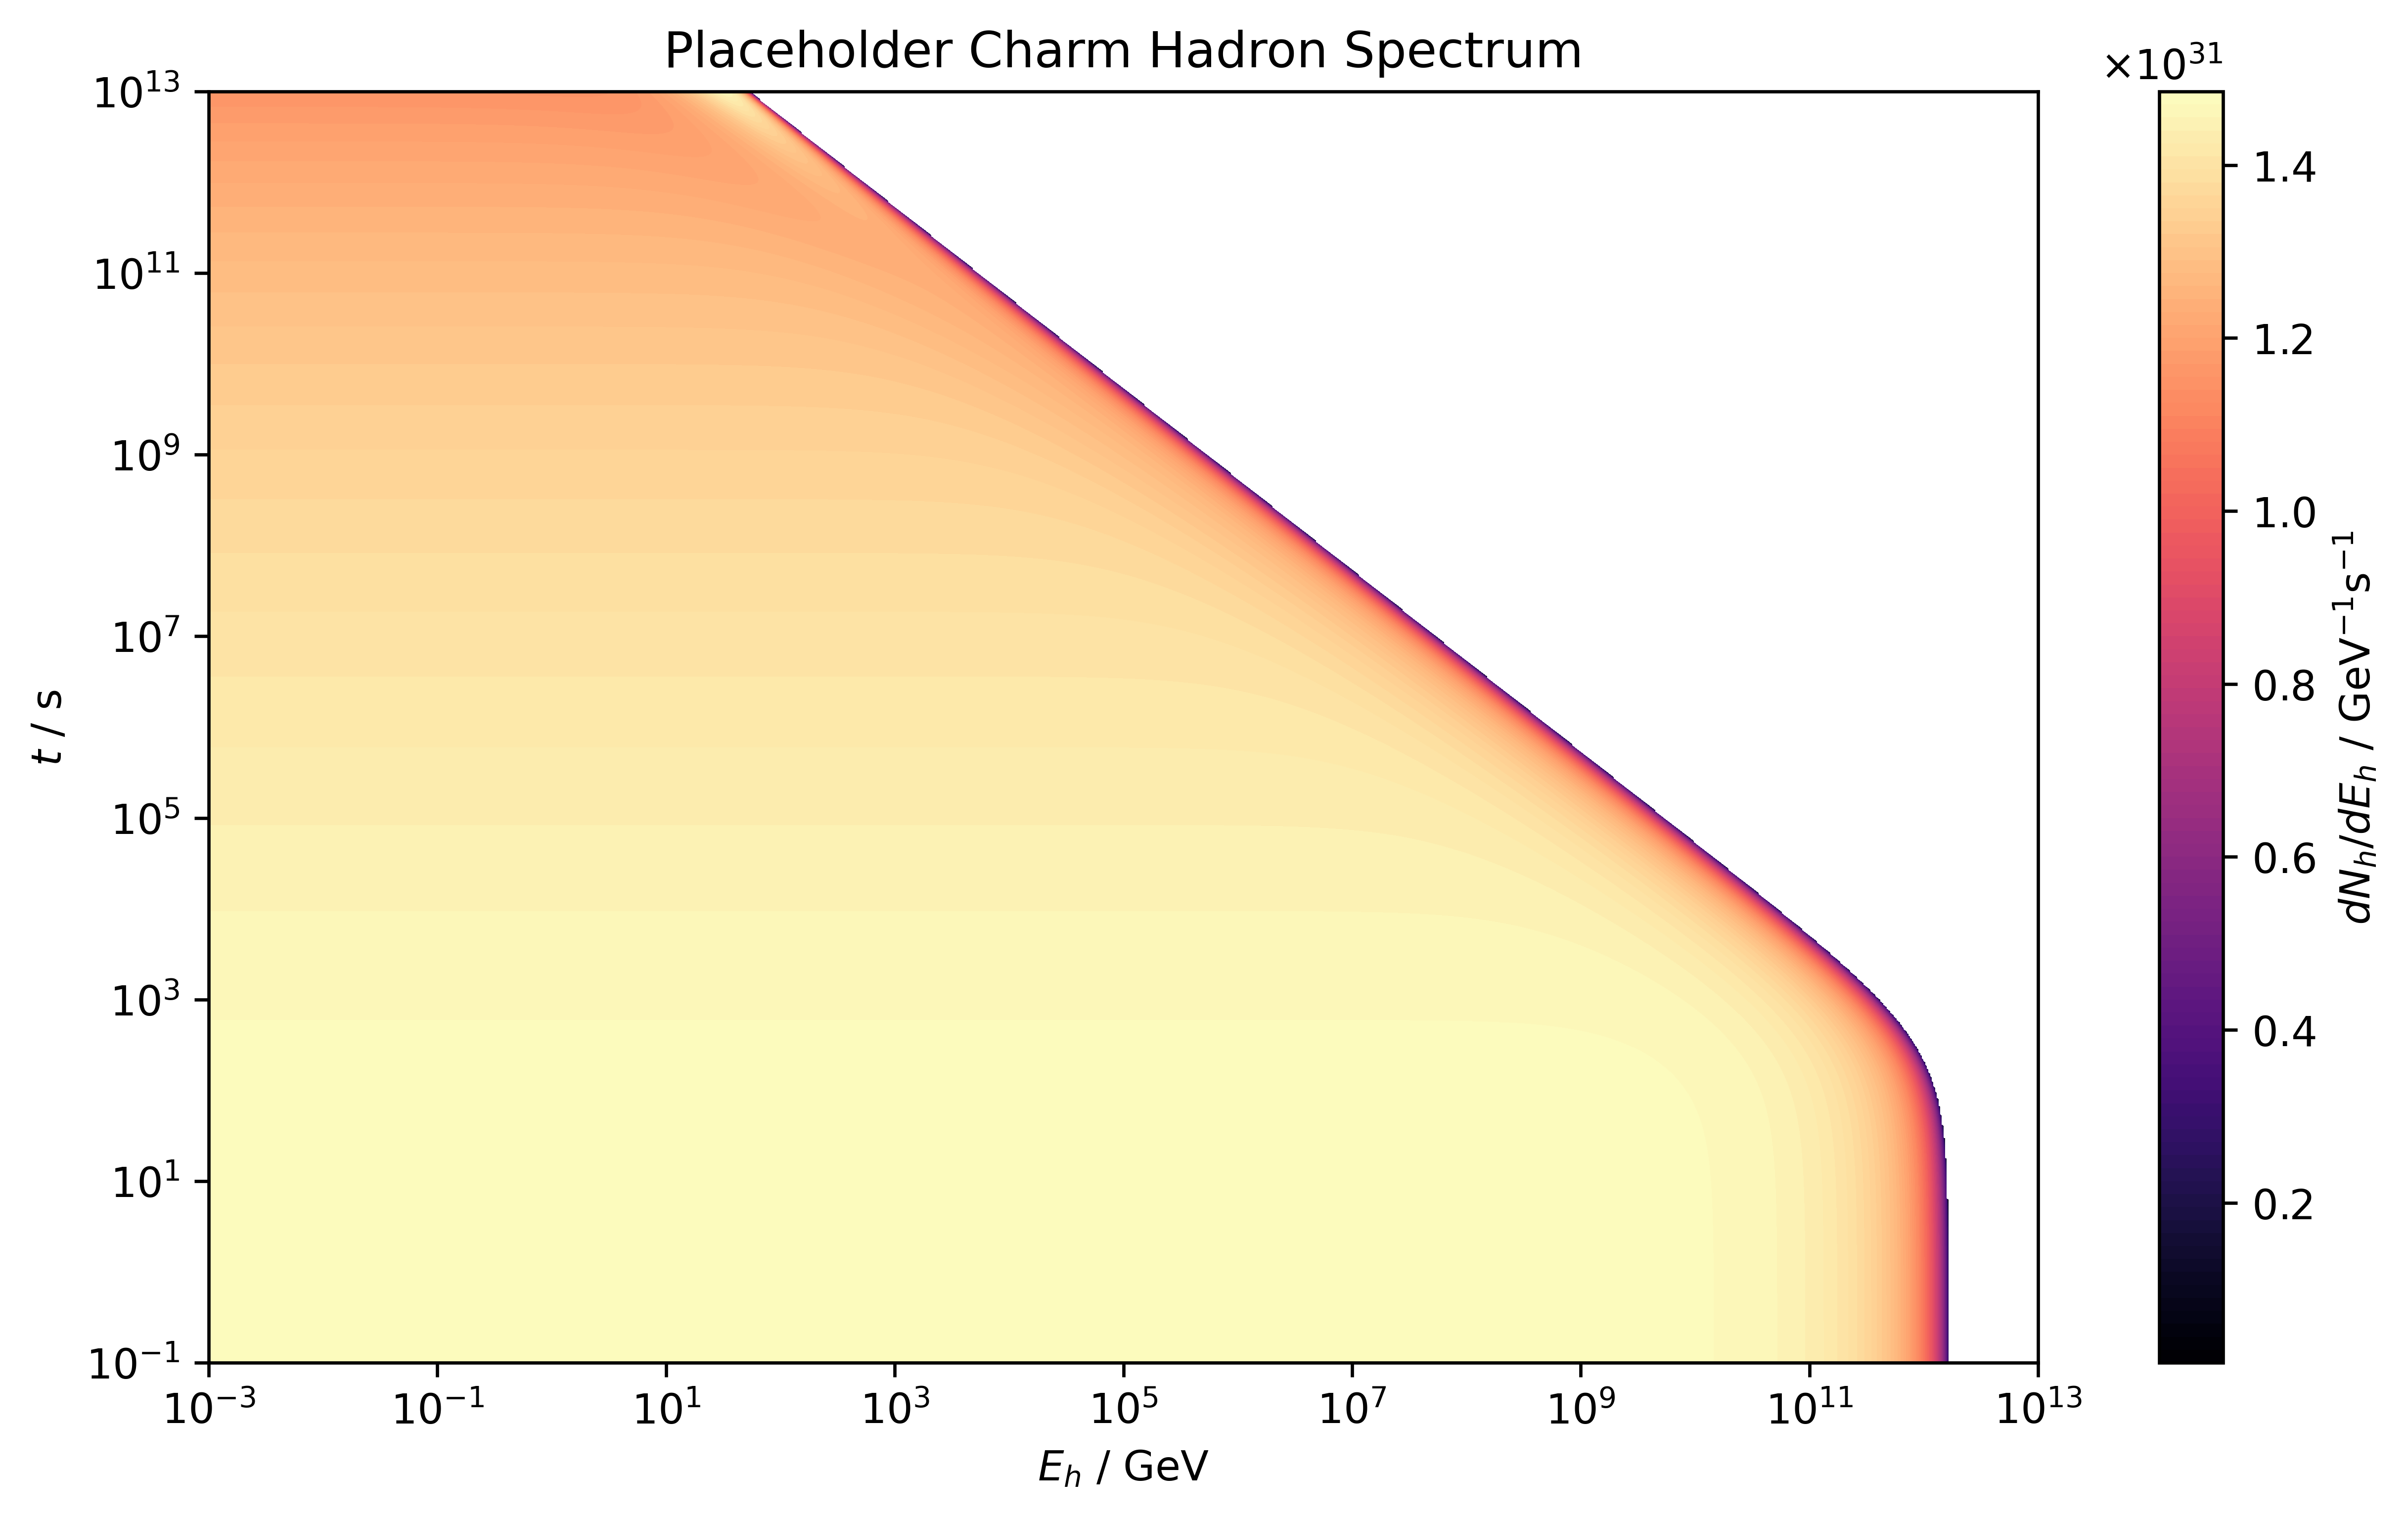

In [6]:
samp_t = np.logspace(-1, 13, 1000)
samp_Eh = np.logspace(-3, 13, 1100)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    test_h_spec = had_spec(samp_t[:, None], samp_Eh[None, :])

x, y, z = samp_Eh, samp_t, test_h_spec
plt.contourf(x, y, z, 100)

tix = np.linspace(0.2e31, 1.4e31, 7)
cbar = plt.colorbar(label=r'$dN_h/dE_h$ / GeV$^{-1}$s$^{-1}$', ticks=tix, pad=0.01)
cbar.formatter.set_useMathText(True)

plt.xscale('log')
plt.yscale('log')

plt.title(r'Placeholder Charm Hadron Spectrum')
plt.xlabel(r'$E_h$ / GeV')
plt.ylabel(r'$t$ / s')

plt.show()
plt.close()

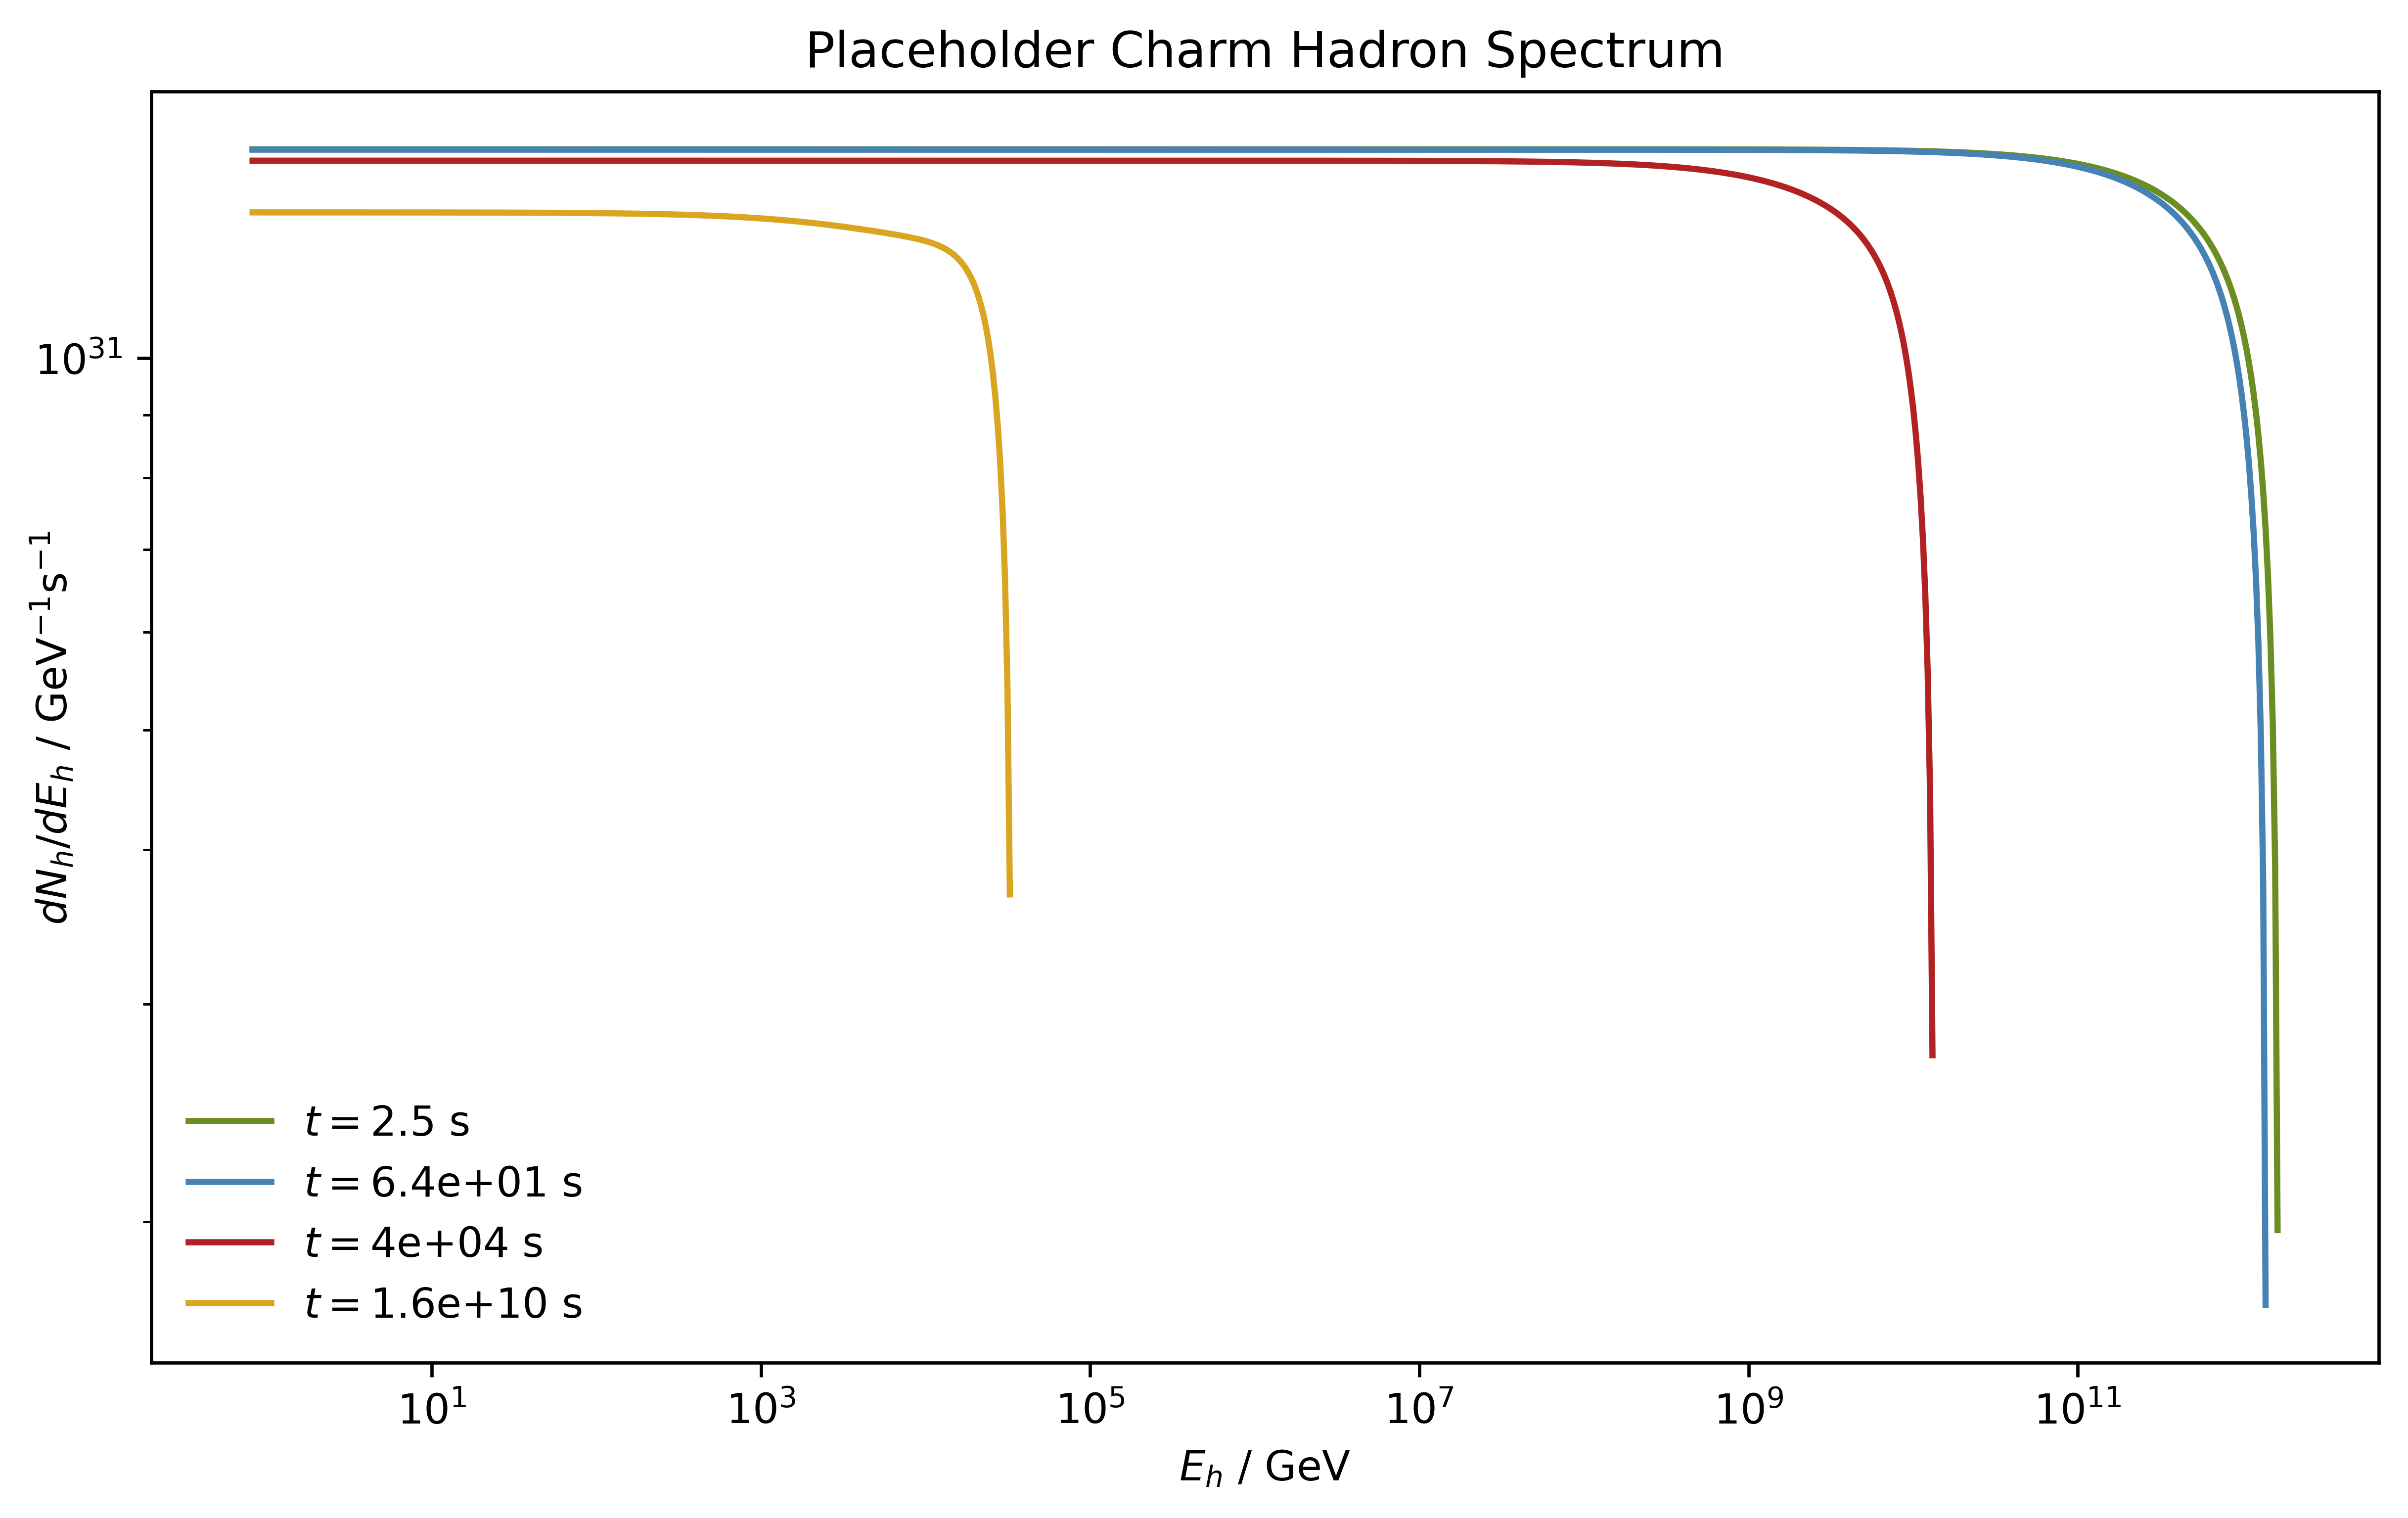

In [7]:
h_spec_1 = test_h_spec[100, :]
h_spec_2 = test_h_spec[200, :]
h_spec_3 = test_h_spec[400, :]
h_spec_4 = test_h_spec[800, :]

plt.plot(samp_Eh[200:], h_spec_1[200:], label=f'$t = ${samp_t[100]:.2} s')
plt.plot(samp_Eh[200:], h_spec_2[200:], label=f'$t = ${samp_t[200]:.2} s')
plt.plot(samp_Eh[200:], h_spec_3[200:], label=f'$t = ${samp_t[400]:.2} s')
plt.plot(samp_Eh[200:], h_spec_4[200:], label=f'$t = ${samp_t[800]:.2} s')

plt.xscale('log')
plt.yscale('log')

plt.title(r'Placeholder Charm Hadron Spectrum')
plt.xlabel(r'$E_h$ / GeV')
plt.ylabel(r'$dN_h/dE_h$ / GeV$^{-1}$s$^{-1}$', labelpad=-10)

plt.legend()

plt.show()
plt.close()

In [8]:
def corr_had_spec(t, Eh):
    c = 29979245800
    e = 4.8032047e-10
    I = 10**45
    B = 10**15
    R = 10**6
    Om = 10**4
    chi = 0.3 * np.pi
    facc = 0.1
    tsd = 2 * c**3 * I / (B**2 * R**6 * Om**2 * (1 + np.sin(chi)**2))
    A = facc * e * B * R**3 * Om**2 / (2 * c**2)
    EM = 624.151 * A / (1 + t / tsd)
    C = 2 * c / (facc * e**2)
    sigpp = 100
    sigph = prot_air_cross_sec(EM)
    kpp = 0.5
    kph = 0.8
    beta = 0.1
    rej = beta * c * t
    Mej = 1.99e34
    mp = 1.67e-24
    nN = 3 * Mej / (4 * np.pi * rej**3 * mp)
    tauh = 0.4e-12
    mh = 1.86
    tdec = tauh * Eh / mh
    tcl = 1 / (kph * sigph * nN * c)
    fpp = kpp * sigpp * nN * rej
    return fpp * (1 - np.exp(-tcl / tdec)) * C * prot_had_diff_cross_sec(EM, Eh) / sigpp

Cooling Modification

$$\begin{align*} \frac{d \dot{N}_h}{dE_h} (t, E_h) \longrightarrow f_{pp} \frac{d \dot{N}_h}{dE_h} (t, E_h)
\left( 1 - \exp\left(-\frac{t_{cl}^h}{t_{dec}^h}\right) \right) \end{align*}$$

$$\begin{align*} f_{pp} = \kappa_{pp}\sigma_{pp} n_N r_{ej} && t_{cl}^h = (\kappa_{ph}\sigma_{ph} n_N c)^{-1} &&
t_{dec}^h = \tau_h E_h m_h^{-1} \end{align*}$$

$$\begin{align*} n_N = 3 (4\pi)^{-1} r_{ej}^{-3} M_{ej} m_{p}^{-1} && r_{ej} = \beta_{ej}ct \end{align*}$$

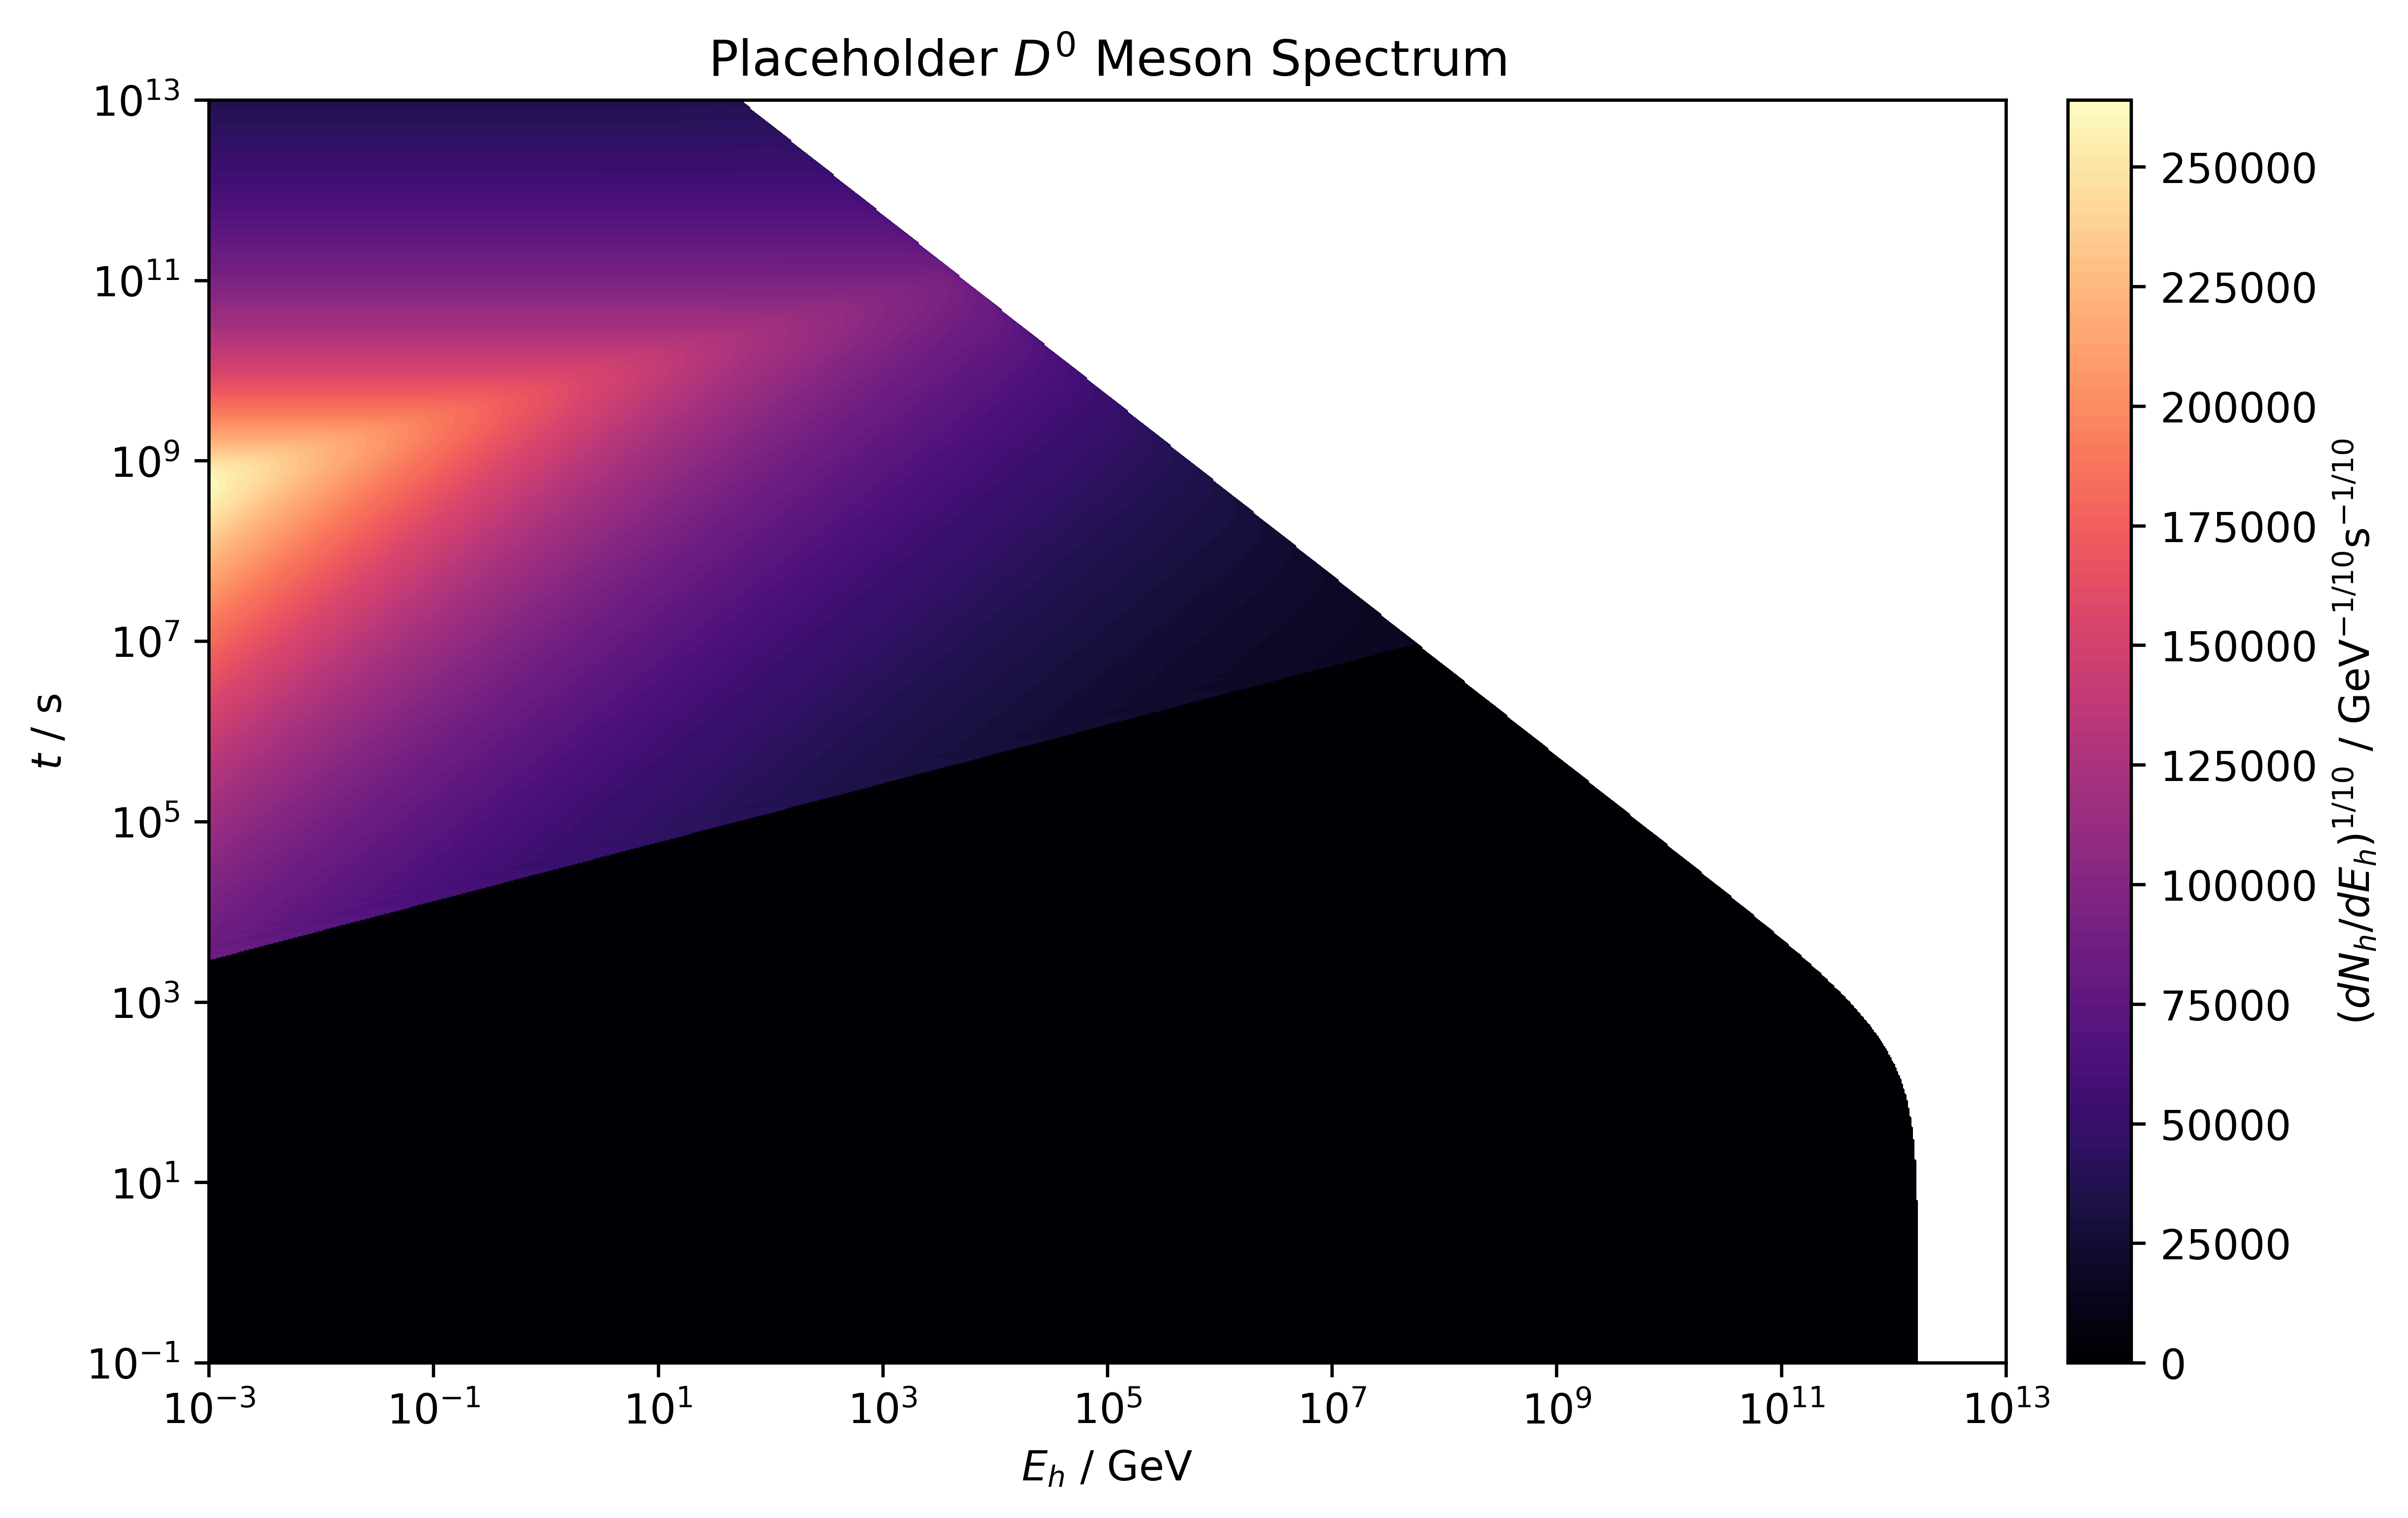

In [31]:
corr_samp_t = np.logspace(-1, 13, 1000)
corr_samp_Eh = np.logspace(-3, 13, 1100)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    corr_test_h_spec = corr_had_spec(samp_t[:, None], samp_Eh[None, :])

x, y, z = corr_samp_Eh, corr_samp_t, corr_test_h_spec
plt.contourf(x, y, z**0.1, 100)

tix = np.linspace(0, 2.5e5, 11)
cbar = plt.colorbar(label=r'$(dN_h/dE_h)^{1/10}$ / GeV$^{-1/10}$s$^{-1/10}$', ticks=tix, pad=0.01)
cbar.formatter.set_useMathText(True)

plt.xscale('log')
plt.yscale('log')

plt.title(r'Placeholder $D^0$ Meson Spectrum')
plt.xlabel(r'$E_h$ / GeV')
plt.ylabel(r'$t$ / s')

plt.show()
plt.close()

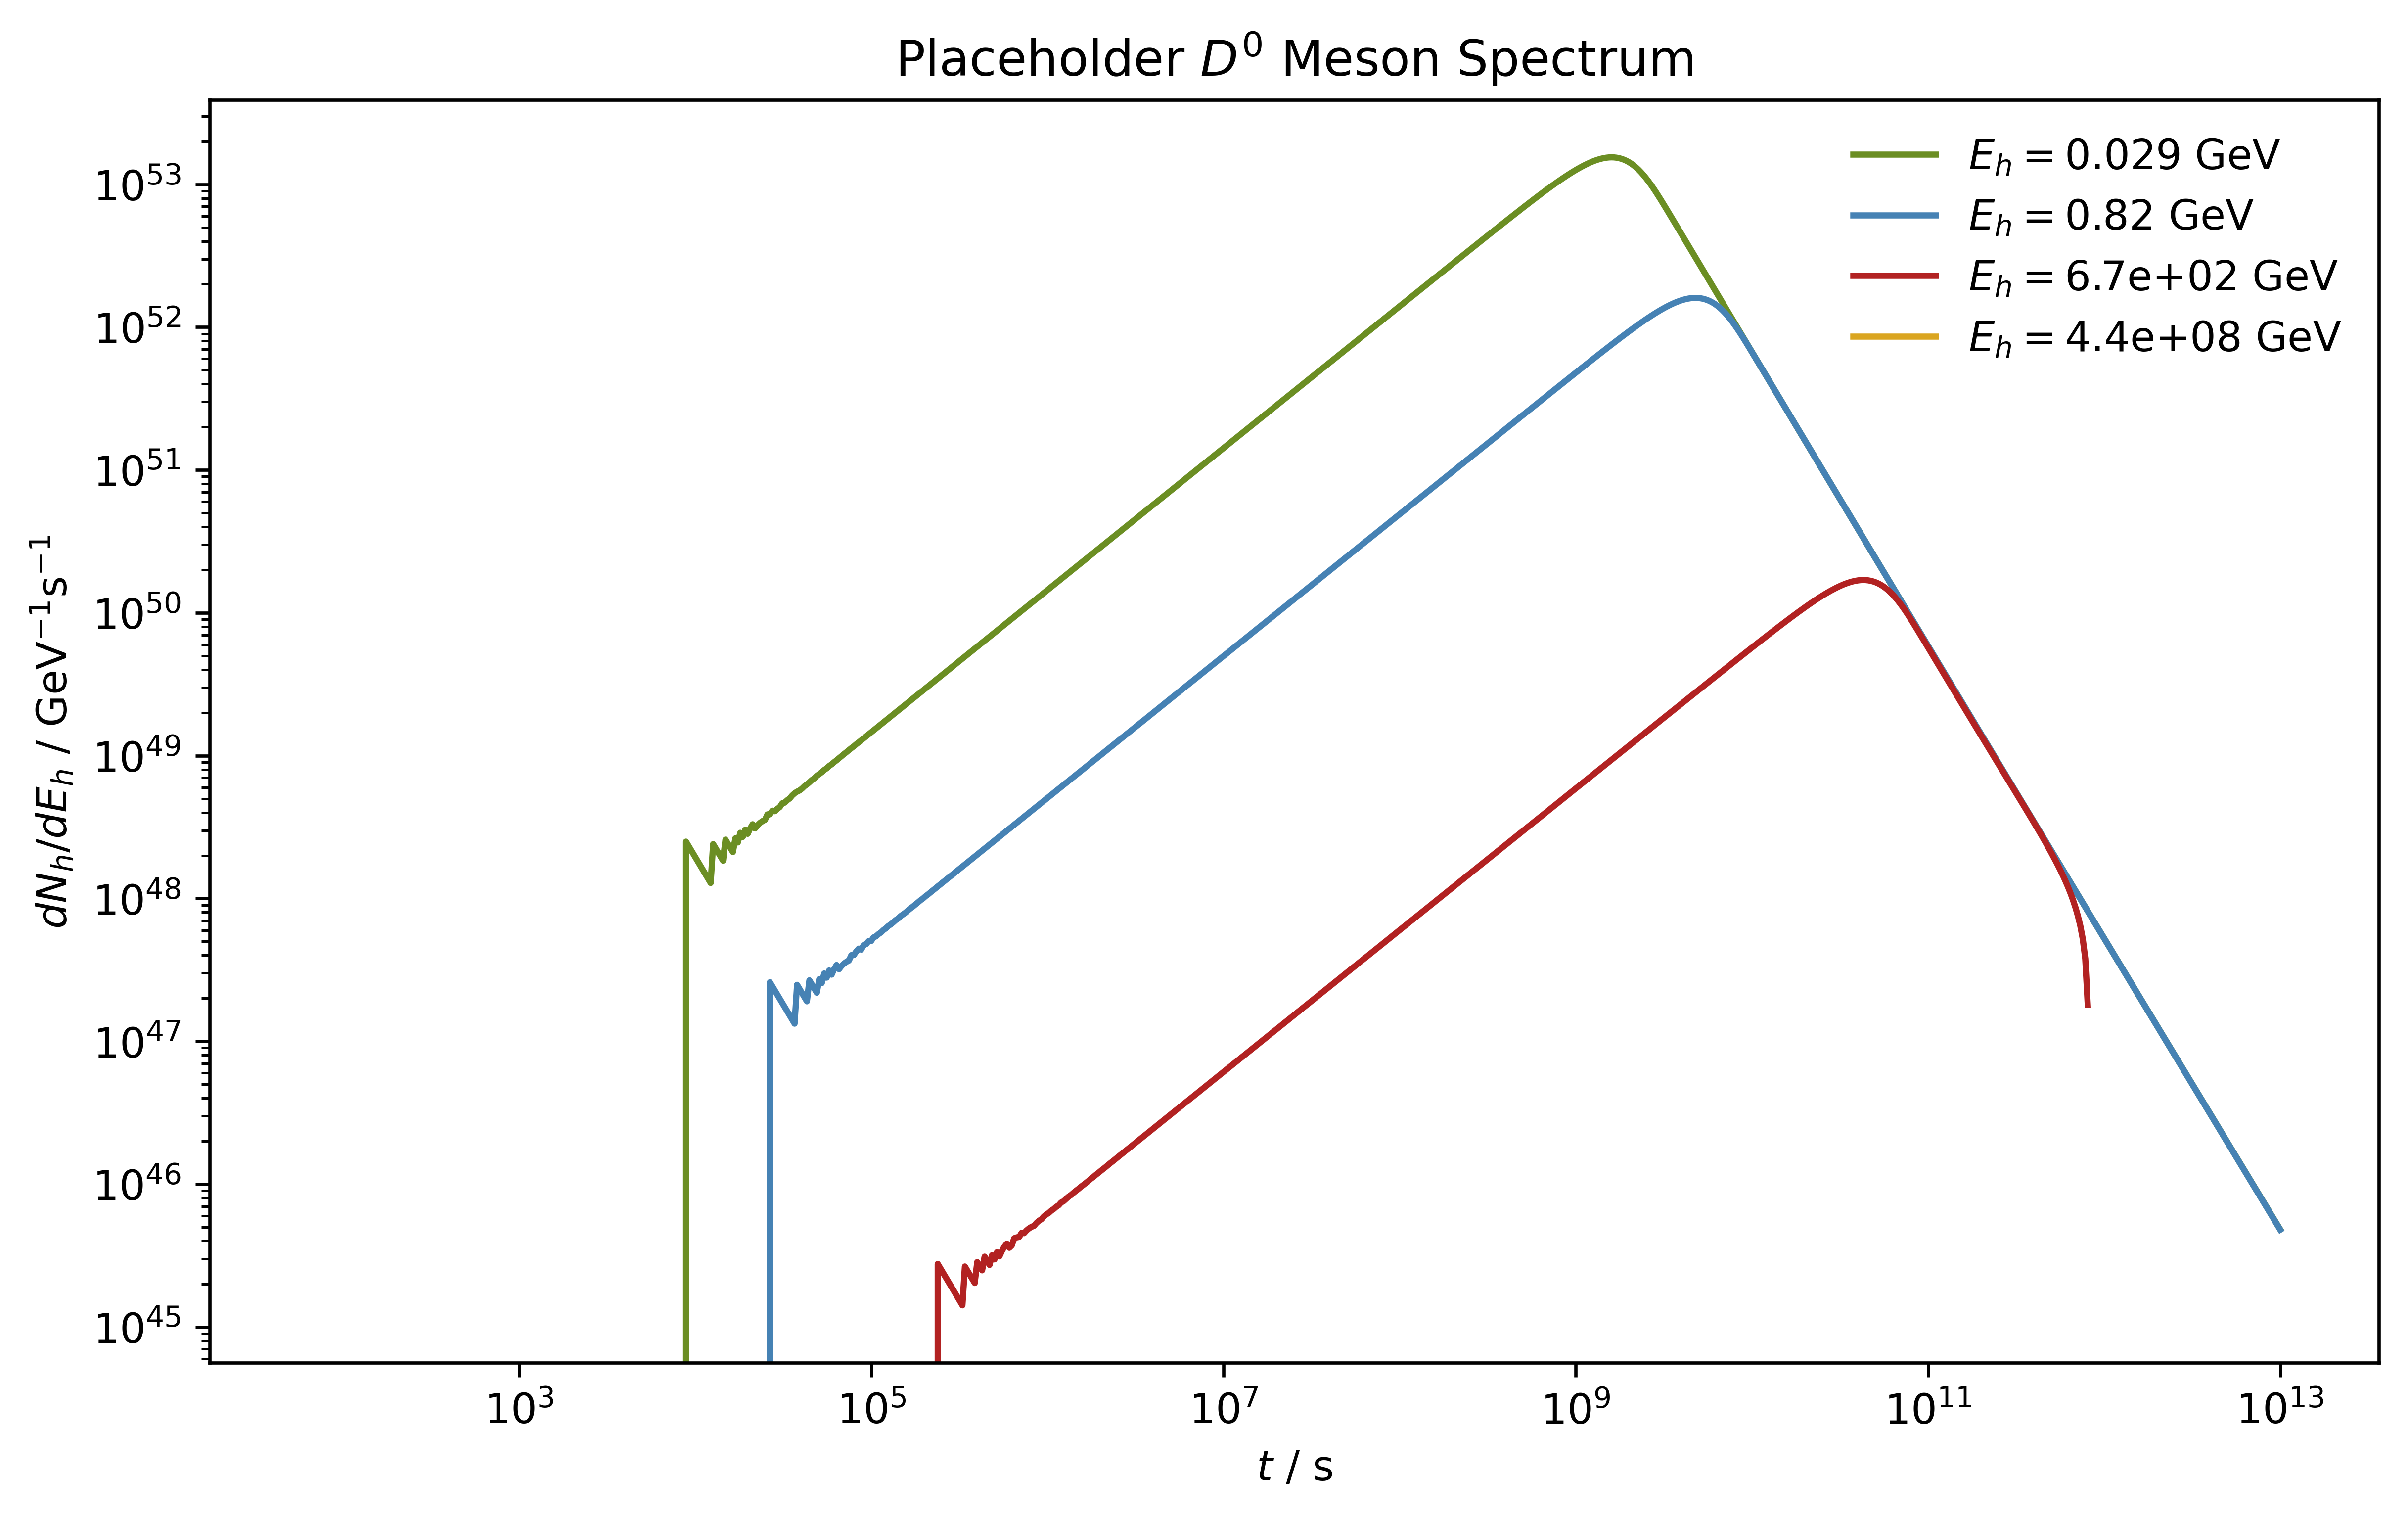

In [37]:
corr_h_spec_1 = corr_test_h_spec[:, 100]
corr_h_spec_2 = corr_test_h_spec[:, 200]
corr_h_spec_3 = corr_test_h_spec[:, 400]
corr_h_spec_4 = corr_test_h_spec[:, 800]

plt.plot(corr_samp_t[200:], corr_h_spec_1[200:], label=f'$E_h = ${corr_samp_Eh[100]:.2} GeV')
plt.plot(corr_samp_t[200:], corr_h_spec_2[200:], label=f'$E_h = ${corr_samp_Eh[200]:.2} GeV')
plt.plot(corr_samp_t[200:], corr_h_spec_3[200:], label=f'$E_h = ${corr_samp_Eh[400]:.2} GeV')
plt.plot(corr_samp_t[200:], corr_h_spec_4[200:], label=f'$E_h = ${corr_samp_Eh[800]:.2} GeV')

plt.xscale('log')
plt.yscale('log')

plt.title(r'Placeholder $D^0$ Meson Spectrum')
plt.xlabel(r'$t$ / s')
plt.ylabel(r'$dN_h/dE_h$ / GeV$^{-1}$s$^{-1}$')

plt.legend()

plt.show()
plt.close()

In [10]:
def dist(Enu, Eh, sh, mh):
    l = sh**2 / mh**2
    y = Enu / Eh
    D = 1 - 8 * l - 12 * l**2 * np.log(l) + 8 * l**3 - l**4
    F = 6 * (1 - 2 * l) * (1 - l)**2 - 4 * (1 - l)**3 - 12 * l**3 * (1 - l) + \
        12 * l**2 * y - 6 * (1 - 2 * l) * y**2 + 4 * y**3 + 12 * l**2 * np.log((1 - y) / l)
    return F / (D * Eh) 

Effective Decay Distribution

$$\begin{align*} F_{h \longrightarrow \nu}(E_\nu, E_h) = \tilde{F}_{h \longrightarrow \nu} (y) / E_h &&
y \equiv E_\nu / E_h \end{align*}$$

Parametrisation

$$\begin{align*} \tilde{F}_{h \longrightarrow \nu} = D^{-1} (\lambda_h) (6(1 - 2\lambda_h)(1 - \lambda_h)^2 - 4(1 - \lambda_h)^3 - 12\lambda_h^3(1 - \lambda_h) + 12\lambda_h^2y - 6(1 - 2\lambda_h)y^2 + 4 y^3 + 12\lambda_h^2 \ln((1 - y)/\lambda_h)) \end{align*}$$

Scaling

$$\begin{align*} D (\lambda_h) = 1 - 8\lambda_h - 12\lambda_h^2 \ln\lambda_h + 8 \lambda_h^3 - \lambda_h^4 &&
\lambda_h \equiv s_h^\text{eff} / m_h^2 \end{align*}$$

Limits

$$\begin{align*} 0 < y < 1 - \lambda_h && E_\nu m_h^2 < E_h (m_h^2 - s_h^\text{eff}) &&
\gamma_\nu m_\nu^2 < \gamma_h (m_h^2 - s_h^\text{eff}) \end{align*}$$

Neutrino Spectrum

$$\begin{align*} &\frac{d\dot{N}_\nu}{dE_\nu} (t, E_\nu) = \int_{E_\nu / (1 - \lambda_h)}^\infty dE_h
\frac{d\dot{N}_h}{dE_h} (t, E_h) F_{h \longrightarrow \nu}(E_\nu, E_h) \\
&\frac{d\dot{N}_\nu}{dE_\nu} (t^i, E_\nu^j) = \sum_k \Delta E_h^k
\frac{d\dot{N}_h}{dE_h} (t^i, E_h^k) F_{h \longrightarrow \nu}(E_\nu^j, E_h^k) &&
\Delta E_h^k \equiv E_h^{k + 1} - E_h^k && E_h^k > \frac{E_\nu^j}{1 - \lambda_h} \end{align*}$$

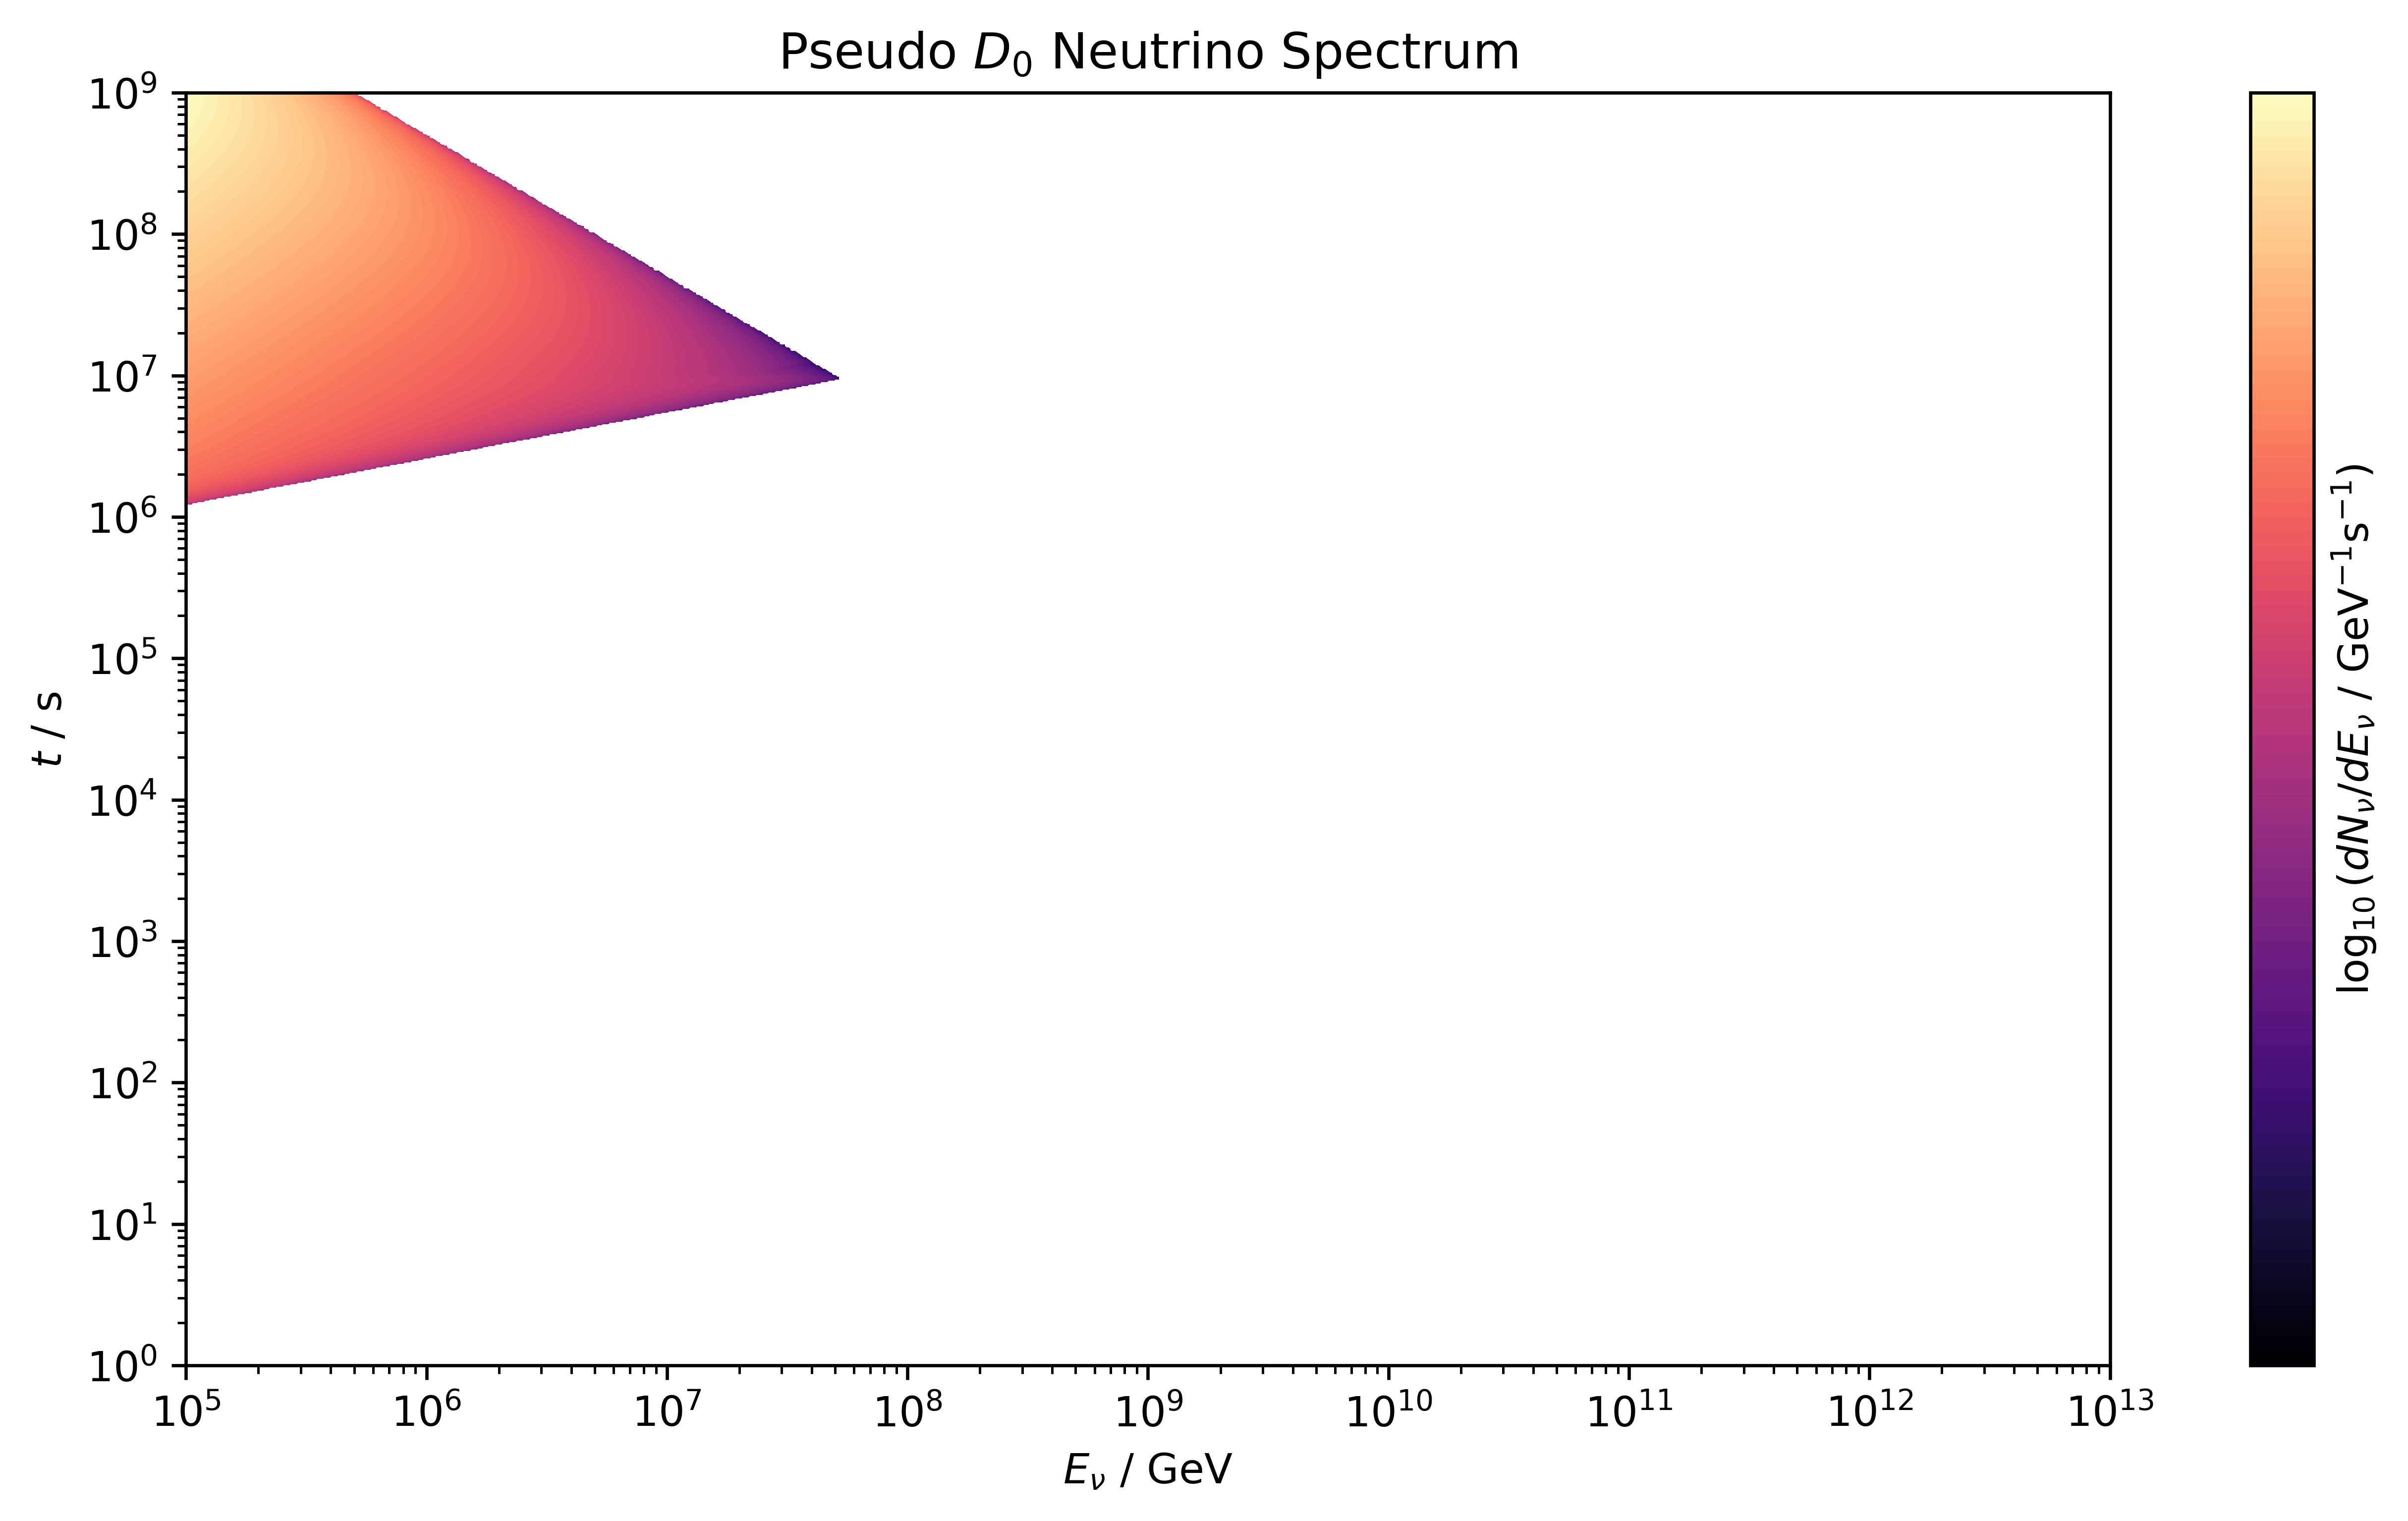

In [38]:
trial_Eh = np.logspace(5, 17, 16000)
trial_t = np.logspace(0, 9, 1000)
trial_Enu = np.logspace(5, 13, 1100)

trial_E = trial_Eh[:-1]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    S = np.nan_to_num(corr_had_spec(trial_t[:, None], trial_E[None, :]))
    D = np.diag(trial_Eh[1:] - trial_Eh[:-1])
    F = np.nan_to_num(dist(trial_Enu[:, None], trial_E[None, :], 0.67, 1.86))
    T = S @ D @ F.T

    plt.contourf(trial_Enu, trial_t, np.log10(T), 100)
tix = np.linspace(26, 32, 7)
cbar = plt.colorbar(label=r'$\log_{10} (dN_\nu/dE_\nu$ / GeV$^{-1}$s$^{-1})$', ticks=tix)

plt.xscale('log')
plt.yscale('log')

plt.title(r'Pseudo $D_0$ Neutrino Spectrum')
plt.xlabel(r'$E_\nu$ / GeV')
plt.ylabel(r'$t$ / s')

plt.show()
plt.close()

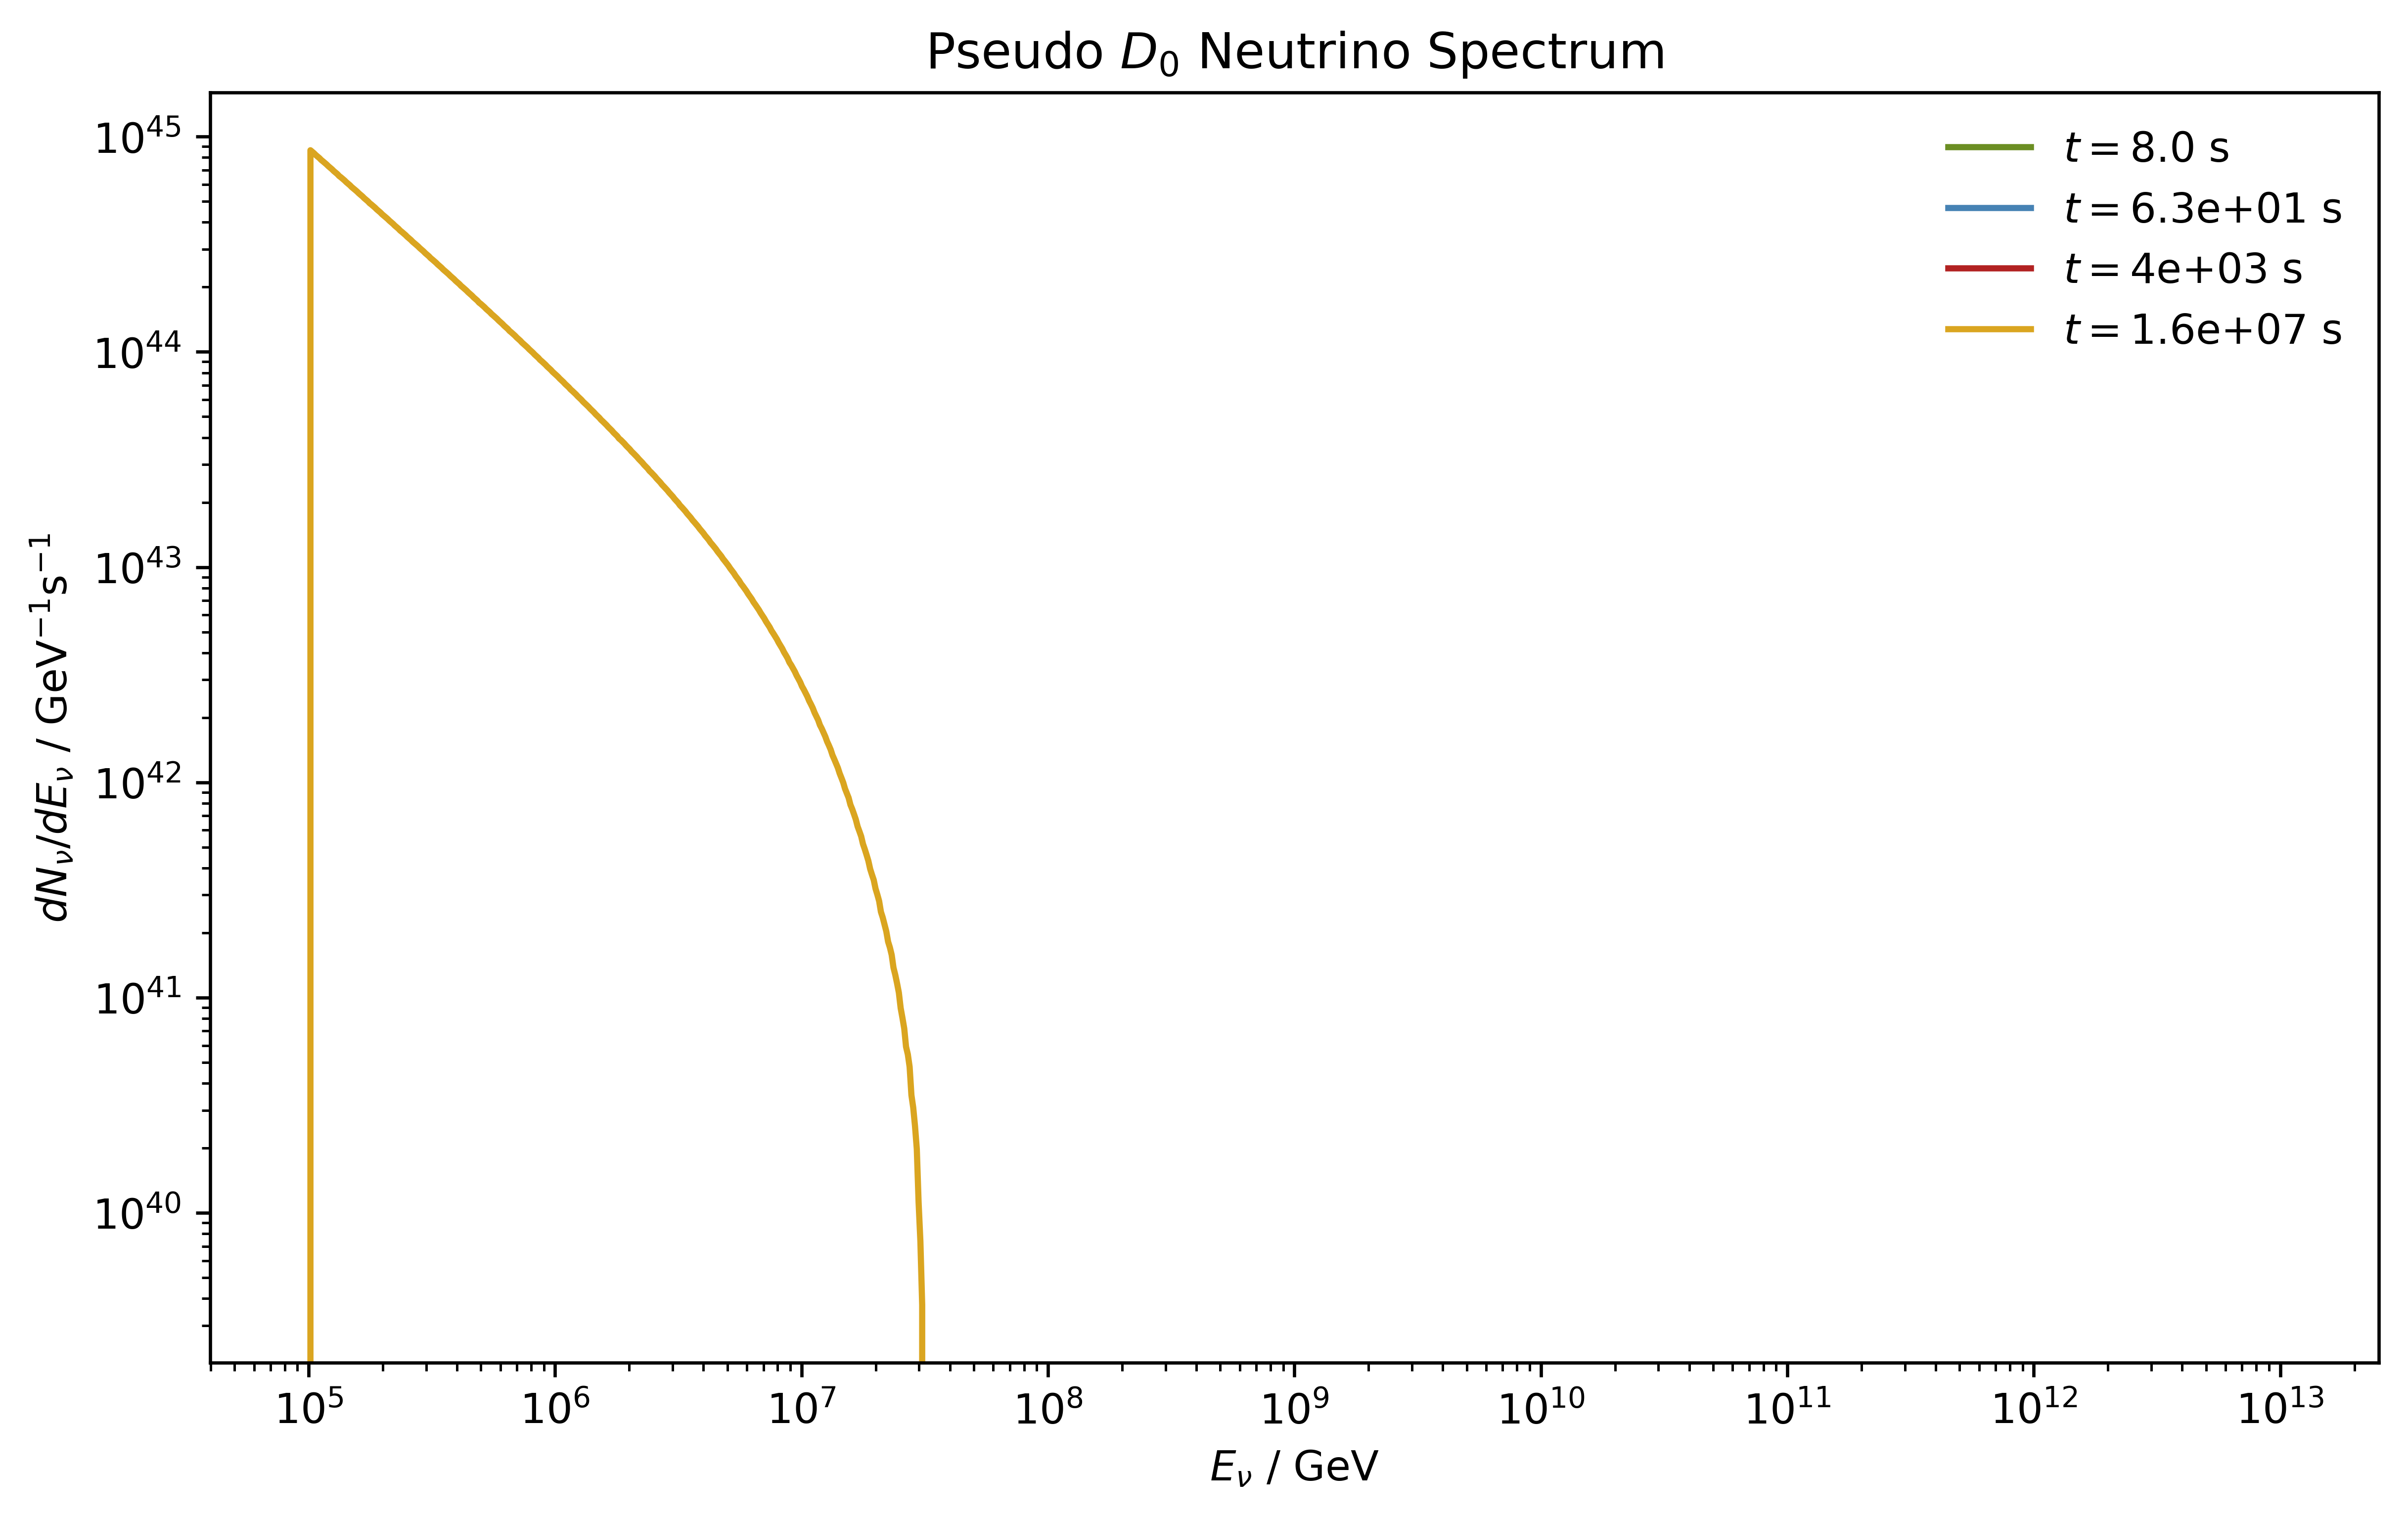

In [39]:
nu_spec_1 = T[100, :]
nu_spec_2 = T[200, :]
nu_spec_3 = T[400, :]
nu_spec_4 = T[800, :]

plt.plot(trial_Enu, nu_spec_1, label=f'$t = ${trial_t[100]:.2} s')
plt.plot(trial_Enu, nu_spec_2, label=f'$t = ${trial_t[200]:.2} s')
plt.plot(trial_Enu, nu_spec_3, label=f'$t = ${trial_t[400]:.2} s')
plt.plot(trial_Enu, nu_spec_4, label=f'$t = ${trial_t[800]:.2} s')

plt.xscale('log')
plt.yscale('log')

plt.title(r'Pseudo $D_0$ Neutrino Spectrum')
plt.xlabel(r'$E_\nu$ / GeV')
plt.ylabel(r'$dN_\nu/dE_\nu$ / GeV$^{-1}$s$^{-1}$')

plt.legend()

plt.show()
plt.close()

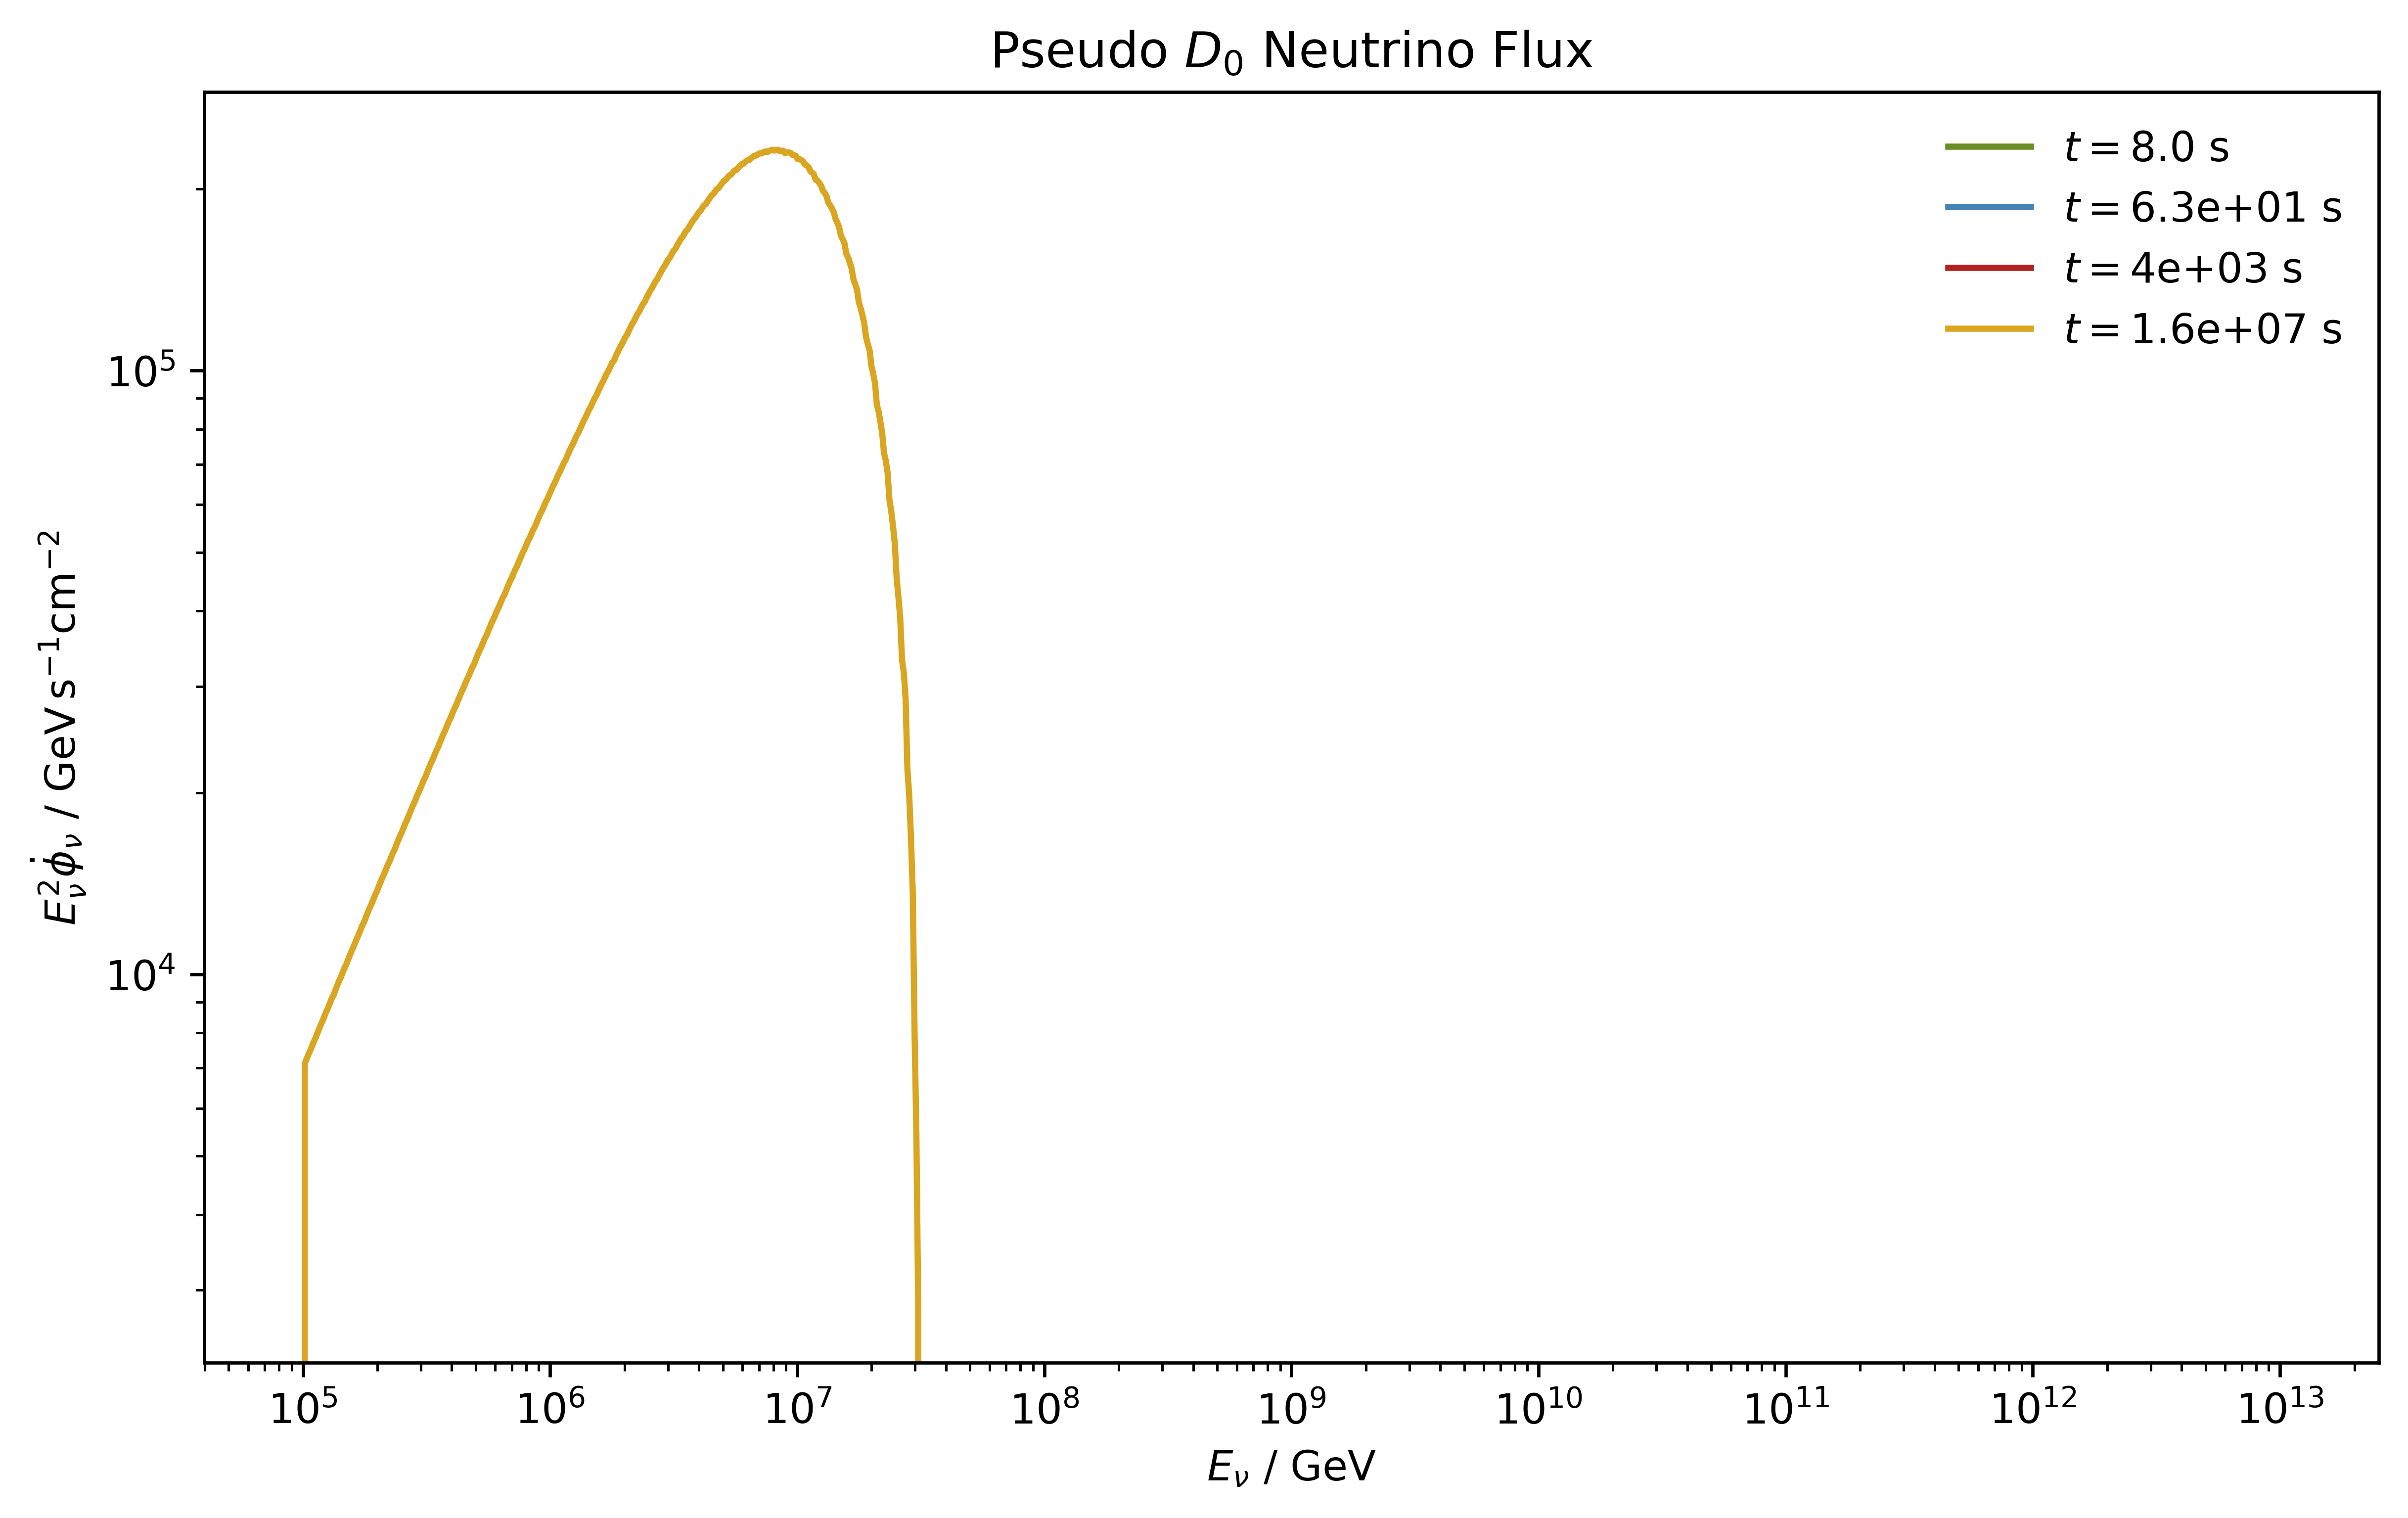

In [40]:
nu_phi_1 = nu_spec_1 / (4 * np.pi * 1e50)
nu_phi_2 = nu_spec_2 / (4 * np.pi * 1e50)
nu_phi_3 = nu_spec_3 / (4 * np.pi * 1e50)
nu_phi_4 = nu_spec_4 / (4 * np.pi * 1e50)

plt.plot(trial_Enu, trial_Enu**2 * nu_phi_1, label=f'$t = ${trial_t[100]:.2} s')
plt.plot(trial_Enu, trial_Enu**2 * nu_phi_2, label=f'$t = ${trial_t[200]:.2} s')
plt.plot(trial_Enu, trial_Enu**2 * nu_phi_3, label=f'$t = ${trial_t[400]:.2} s')
plt.plot(trial_Enu, trial_Enu**2 * nu_phi_4, label=f'$t = ${trial_t[800]:.2} s')

plt.xscale('log')
plt.yscale('log')

plt.title(r'Pseudo $D_0$ Neutrino Flux')
plt.xlabel(r'$E_\nu$ / GeV')
plt.ylabel(r'$E_\nu^2 \dot{\phi}_\nu$ / GeV$\,$s$^{-1}$cm$^{-2}$')

plt.legend()

plt.show()
plt.close()

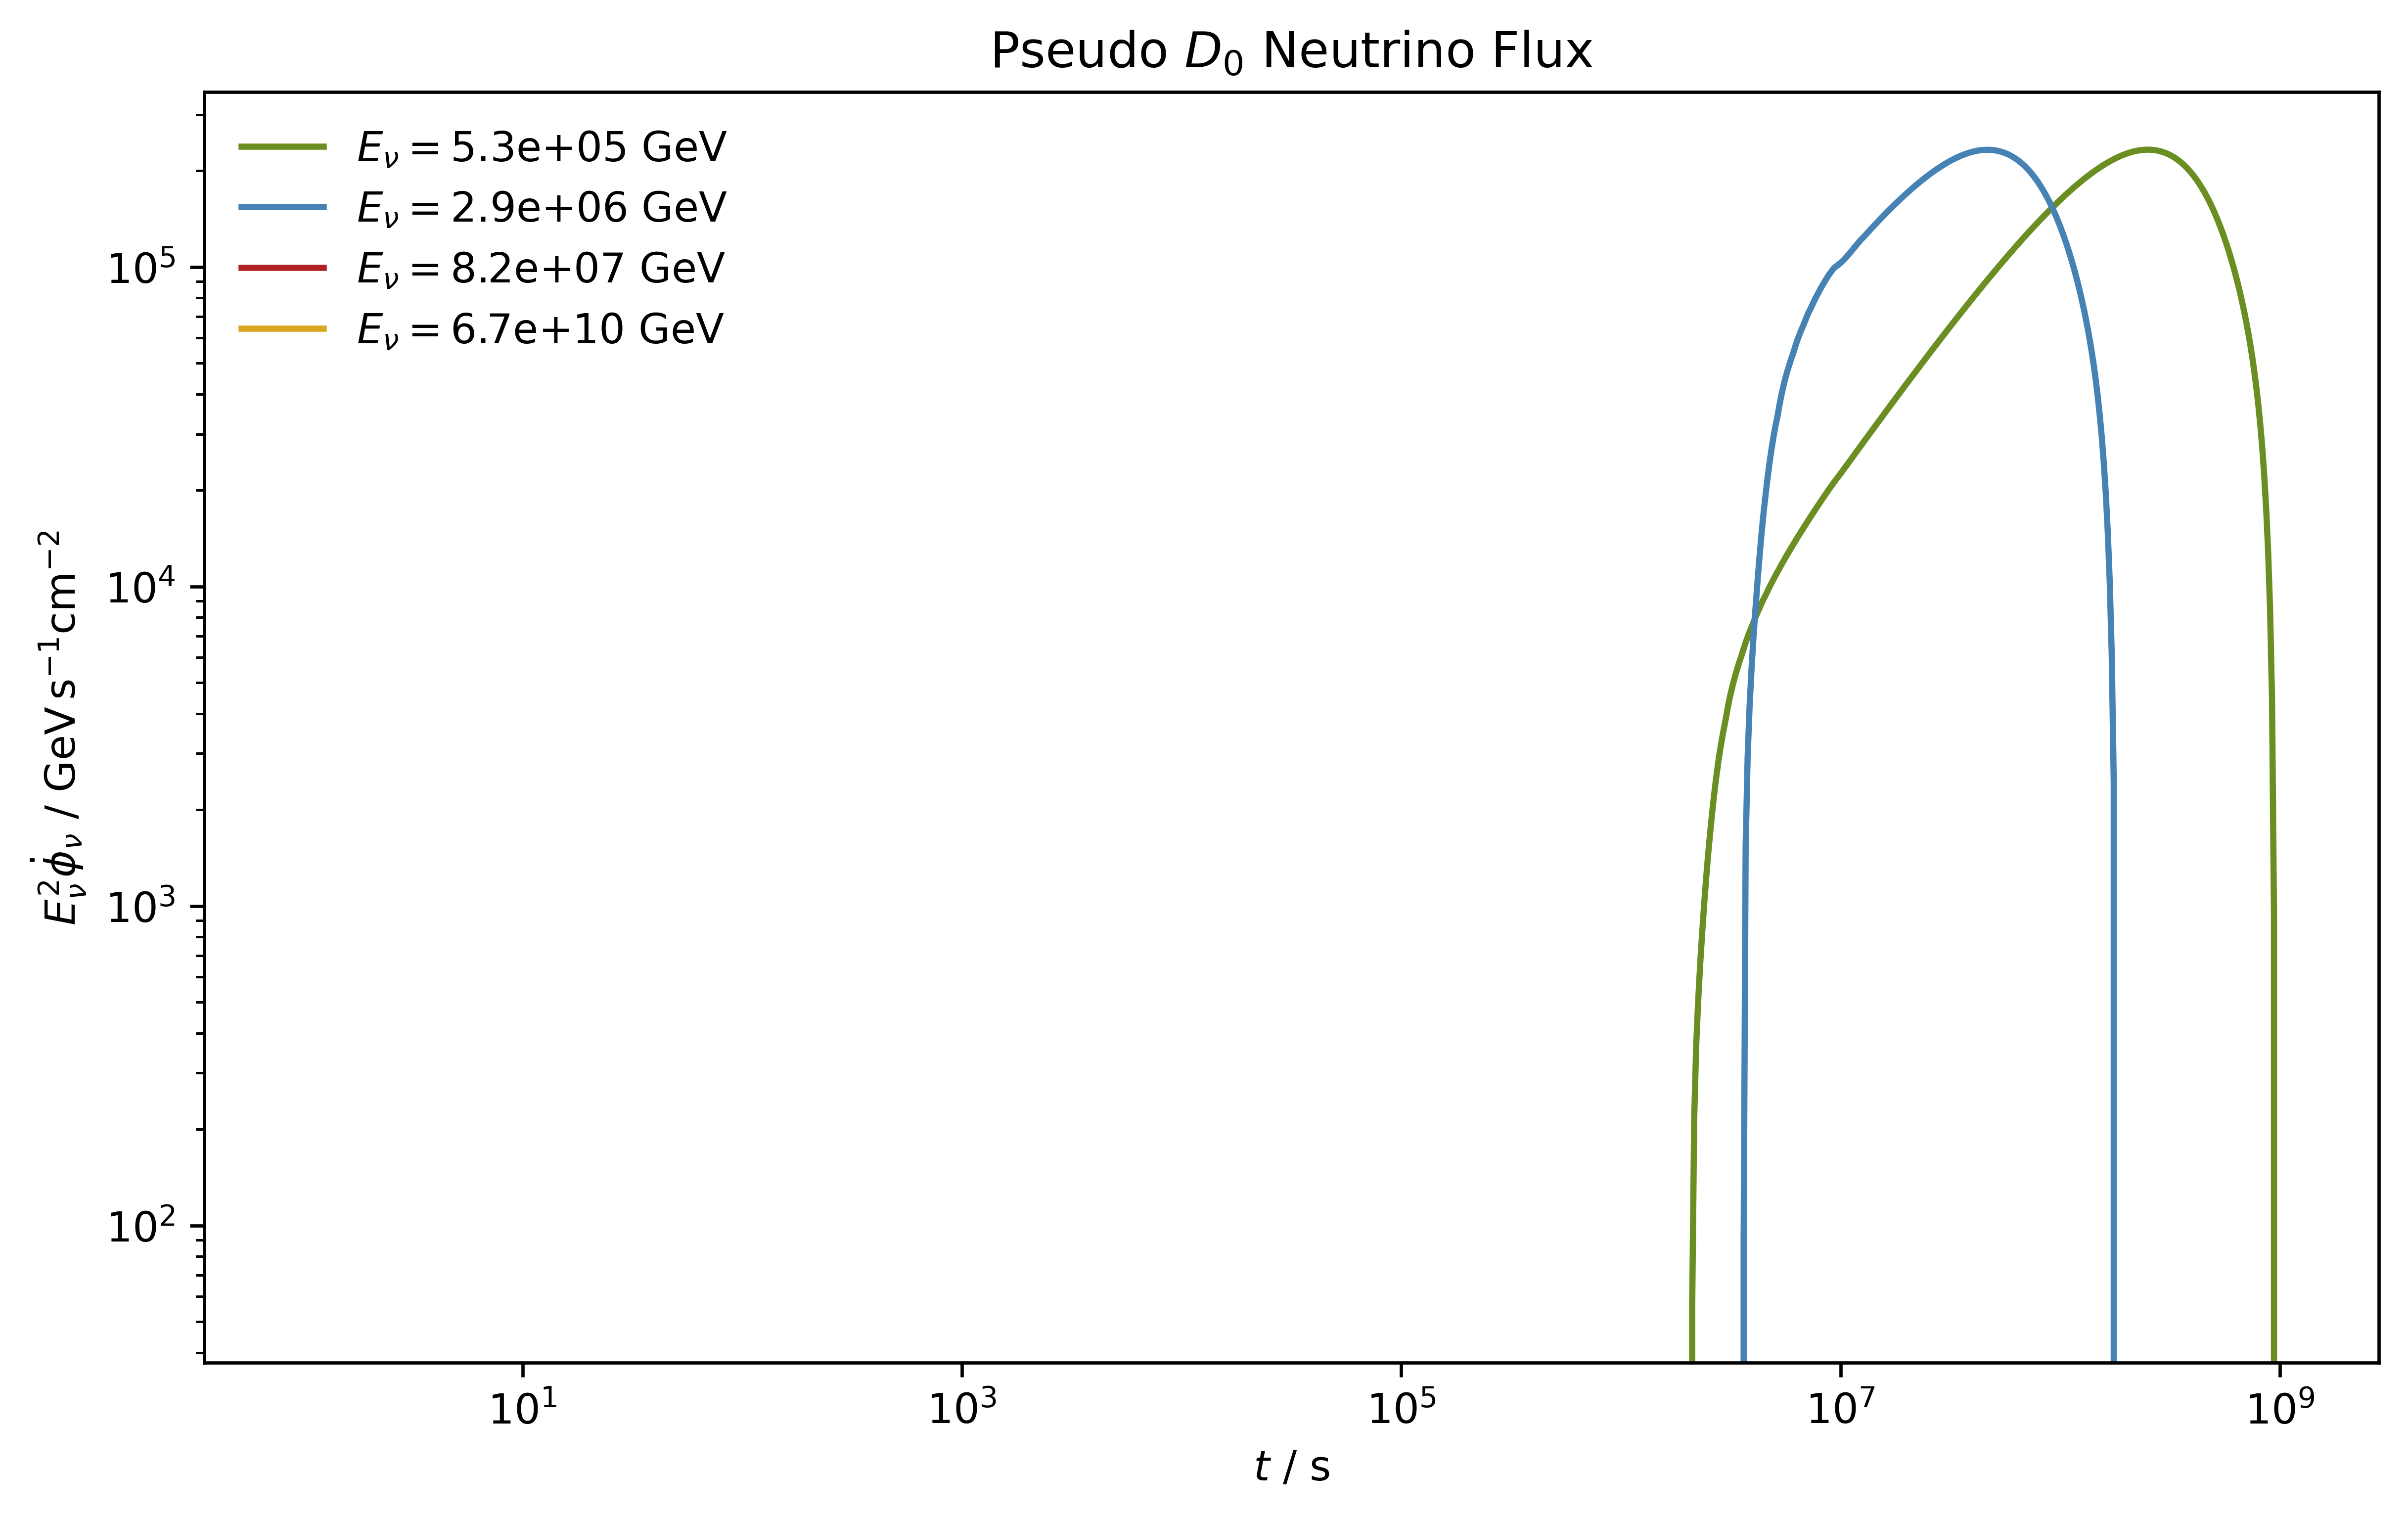

In [41]:
nu_phi_5 = T[:, 100] / (4 * np.pi * 1e50)
nu_phi_6 = T[:, 200] / (4 * np.pi * 1e50)
nu_phi_7 = T[:, 400] / (4 * np.pi * 1e50)
nu_phi_8 = T[:, 800] / (4 * np.pi * 1e50)

plt.plot(trial_t, trial_Enu[100]**2 * nu_phi_5, label=f'$E_\\nu = ${trial_Enu[100]:.2} GeV')
plt.plot(trial_t, trial_Enu[200]**2 * nu_phi_6, label=f'$E_\\nu = ${trial_Enu[200]:.2} GeV')
plt.plot(trial_t, trial_Enu[400]**2 * nu_phi_7, label=f'$E_\\nu = ${trial_Enu[400]:.2} GeV')
plt.plot(trial_t, trial_Enu[800]**2 * nu_phi_8, label=f'$E_\\nu = ${trial_Enu[800]:.2} GeV')

plt.xscale('log')
plt.yscale('log')

plt.title(r'Pseudo $D_0$ Neutrino Flux')
plt.xlabel(r'$t$ / s')
plt.ylabel(r'$E_\nu^2 \dot{\phi}_\nu$ / GeV$\,$s$^{-1}$cm$^{-2}$')

plt.legend()

plt.show()
plt.close()

Single Source Flux

$$\begin{align*} \dot{\phi}_\nu(t, E_\nu) = (4\pi d^2)^{-1} \frac{d\dot{N}_\nu}{dE_\nu}(t, E_\nu) \end{align*}$$

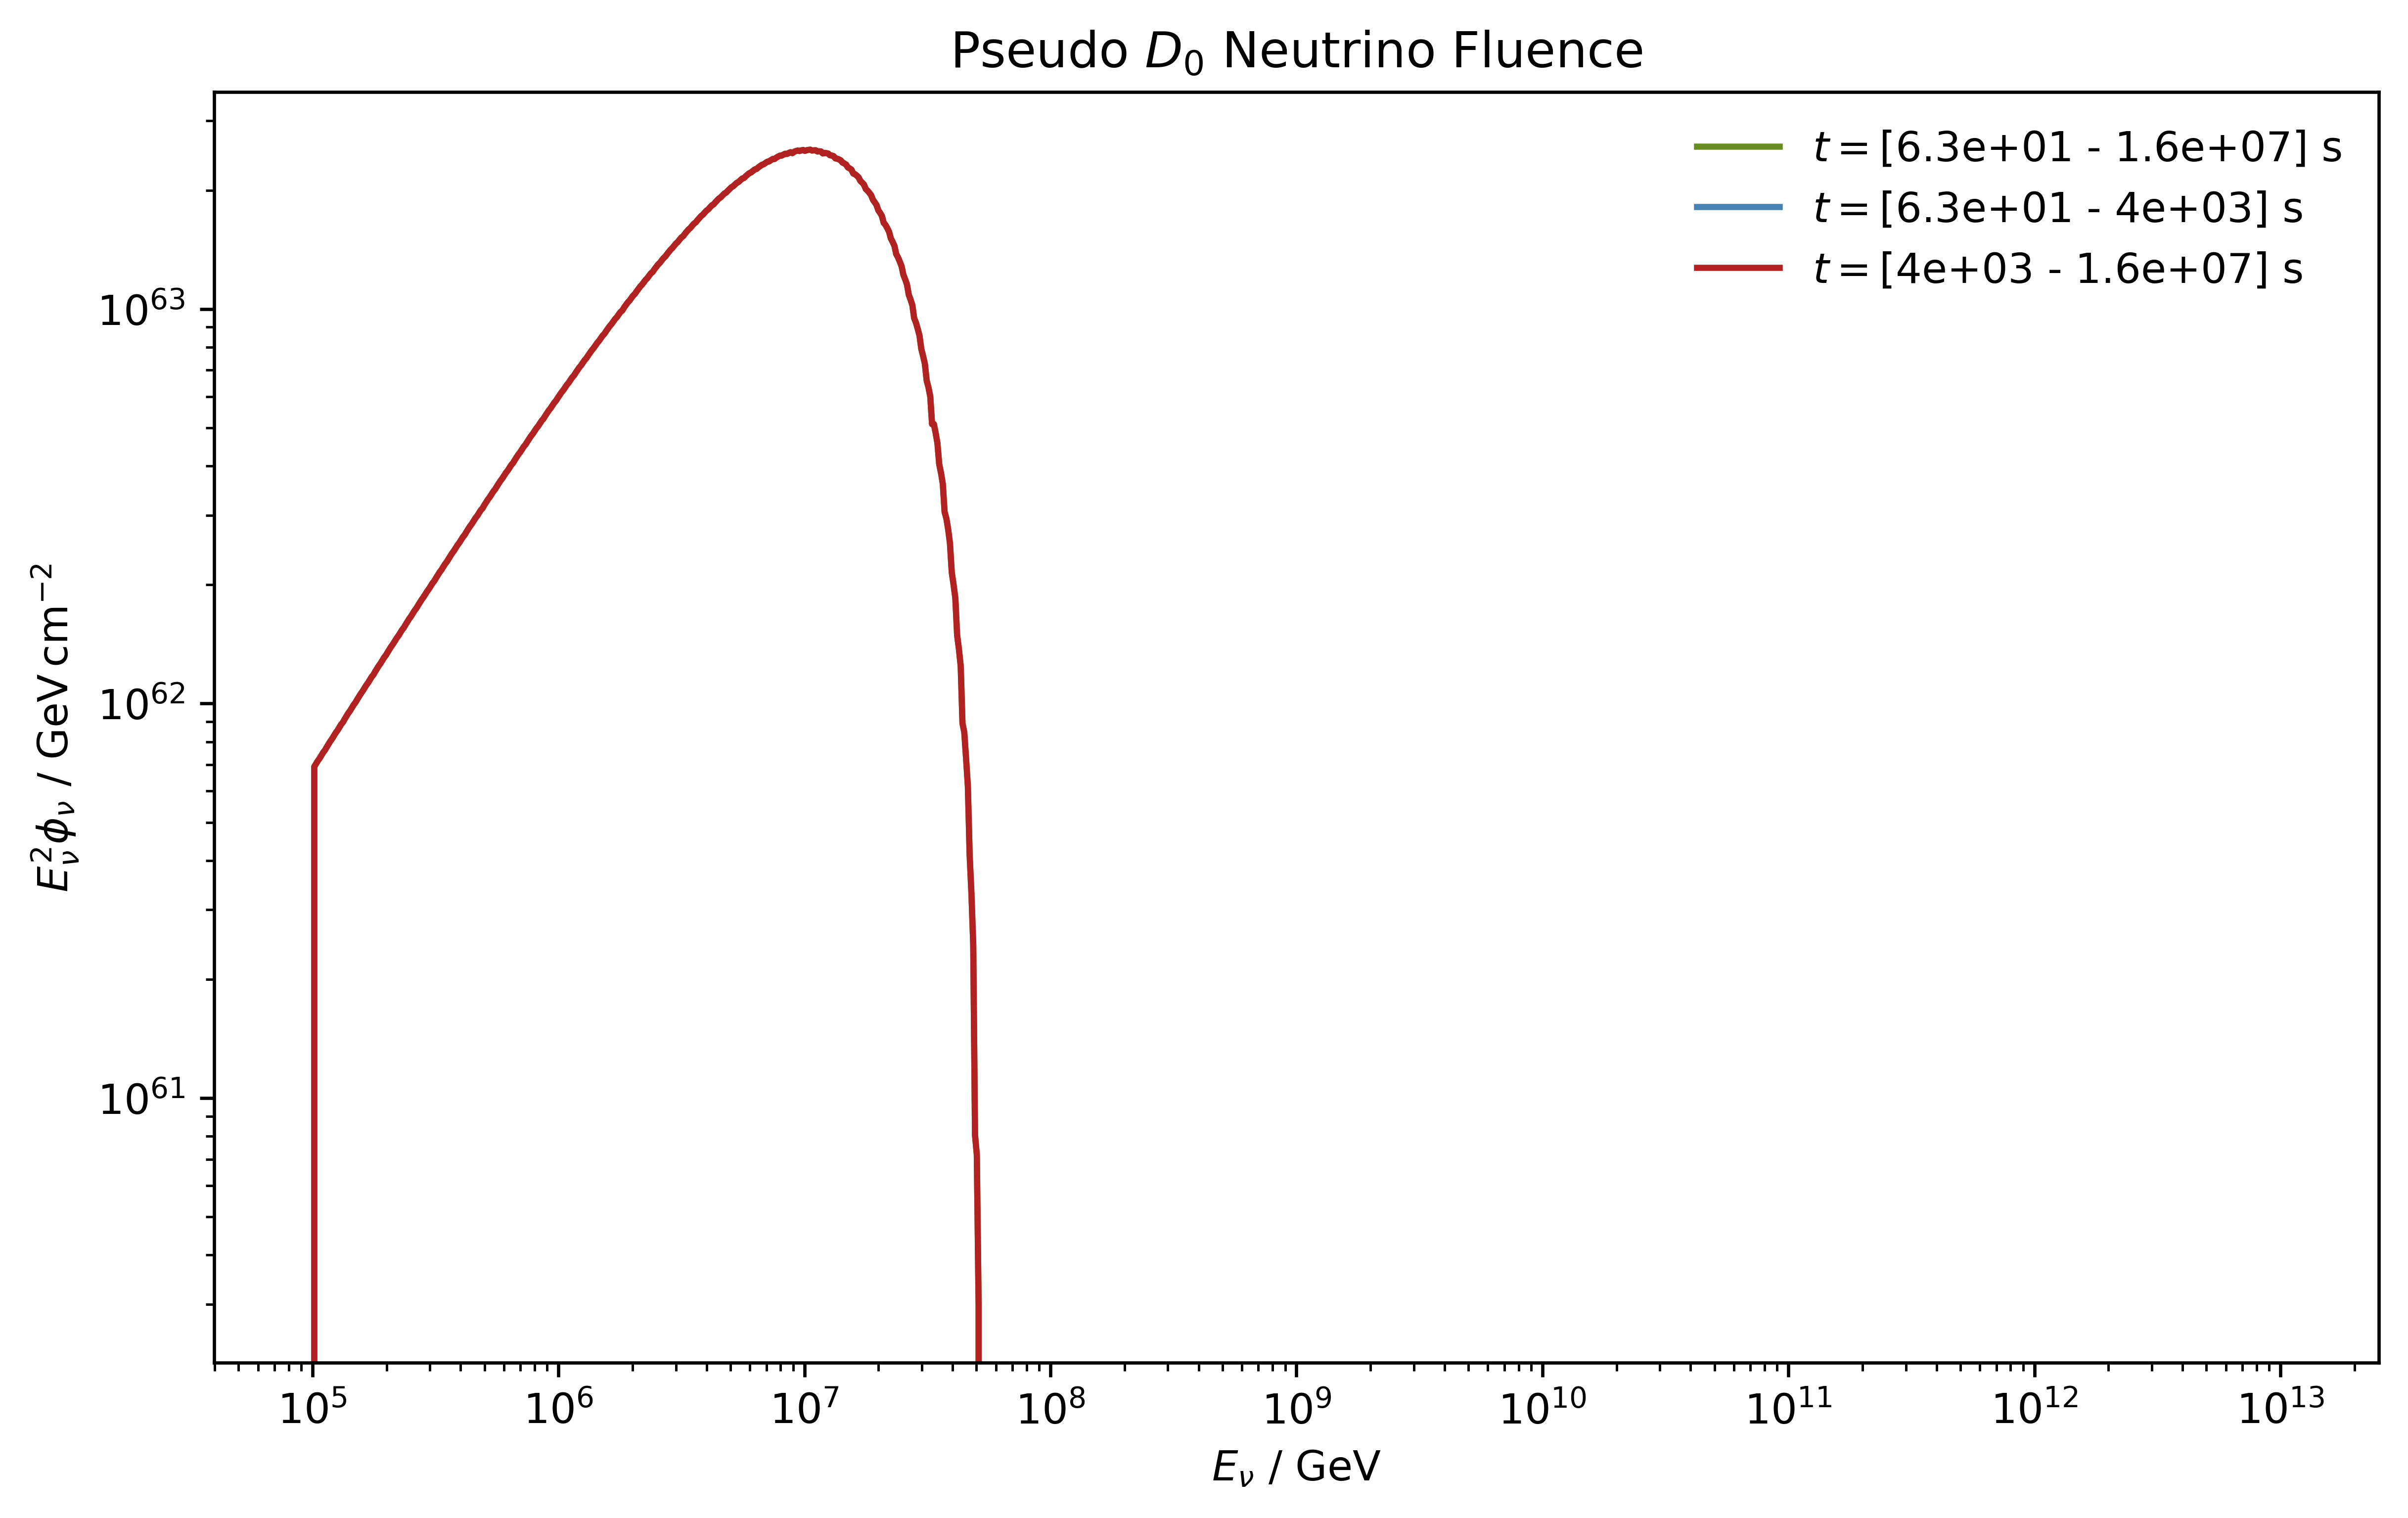

In [42]:
nu_Phi_1 = np.sum((trial_t[200:800] - trial_t[199:799]) * T[200:800, :].T, axis=1)
nu_Phi_2 = np.sum((trial_t[200:400] - trial_t[199:399]) * T[200:400, :].T, axis=1)
nu_Phi_3 = np.sum((trial_t[400:800] - trial_t[399:799]) * T[400:800, :].T, axis=1)

plt.plot(trial_Enu, trial_Enu**2 * nu_Phi_1, label=f'$t = $[{trial_t[200]:.2} - {trial_t[800]:.2}] s')
plt.plot(trial_Enu, trial_Enu**2 * nu_Phi_2, label=f'$t = $[{trial_t[200]:.2} - {trial_t[400]:.2}] s')
plt.plot(trial_Enu, trial_Enu**2 * nu_Phi_3, label=f'$t = $[{trial_t[400]:.2} - {trial_t[800]:.2}] s')

plt.xscale('log')
plt.yscale('log')

plt.title(r'Pseudo $D_0$ Neutrino Fluence')
plt.xlabel(r'$E_\nu$ / GeV')
plt.ylabel(r'$E_\nu^2 \phi_\nu$ / GeV$\,$cm$^{-2}$')

plt.legend()

plt.show()
plt.close()

Single Source Fluence

$$\begin{align*} \phi_\nu(E_\nu) &= \int_{t_1}^{t_2} dt \dot{\phi}_\nu(t, E_\nu) \\ 
\phi_\nu(E_\nu^j) &= \sum_i \Delta t^i \dot{\phi}_\nu(t^i, E_\nu^j) & \Delta t^i \equiv t^{i + 1} - t^i \end{align*}$$

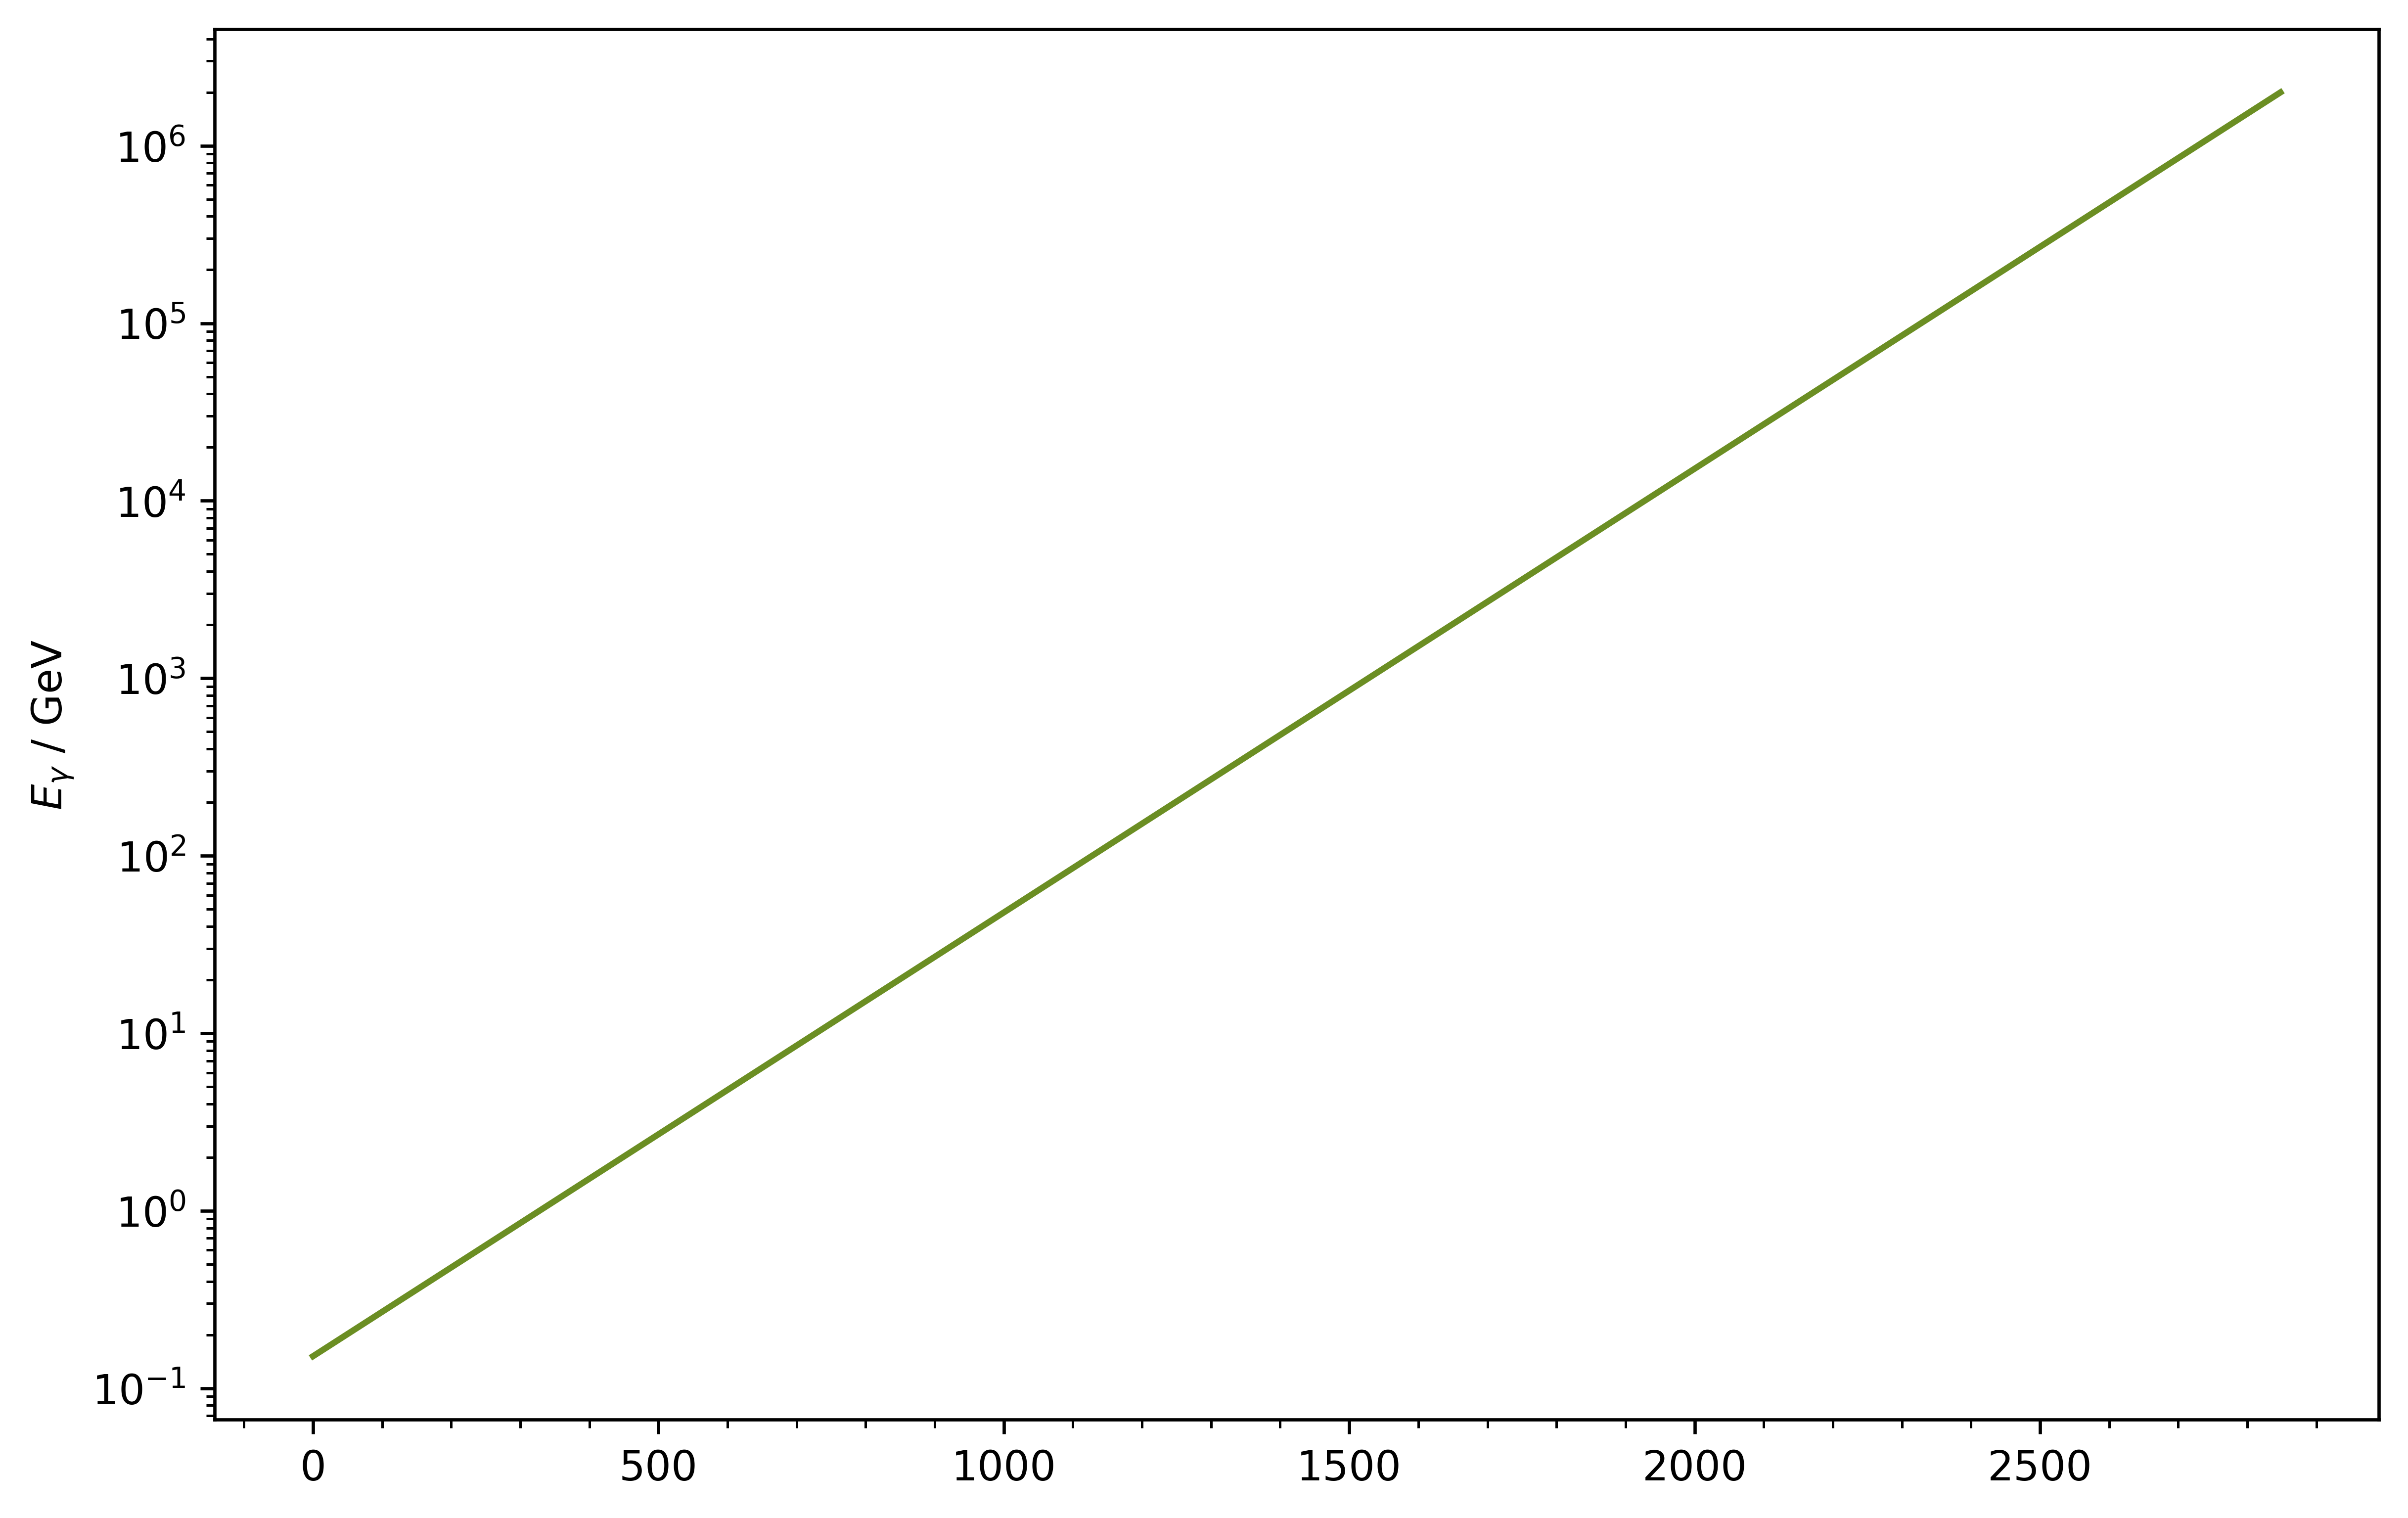

2849 logarithmically distributed entries


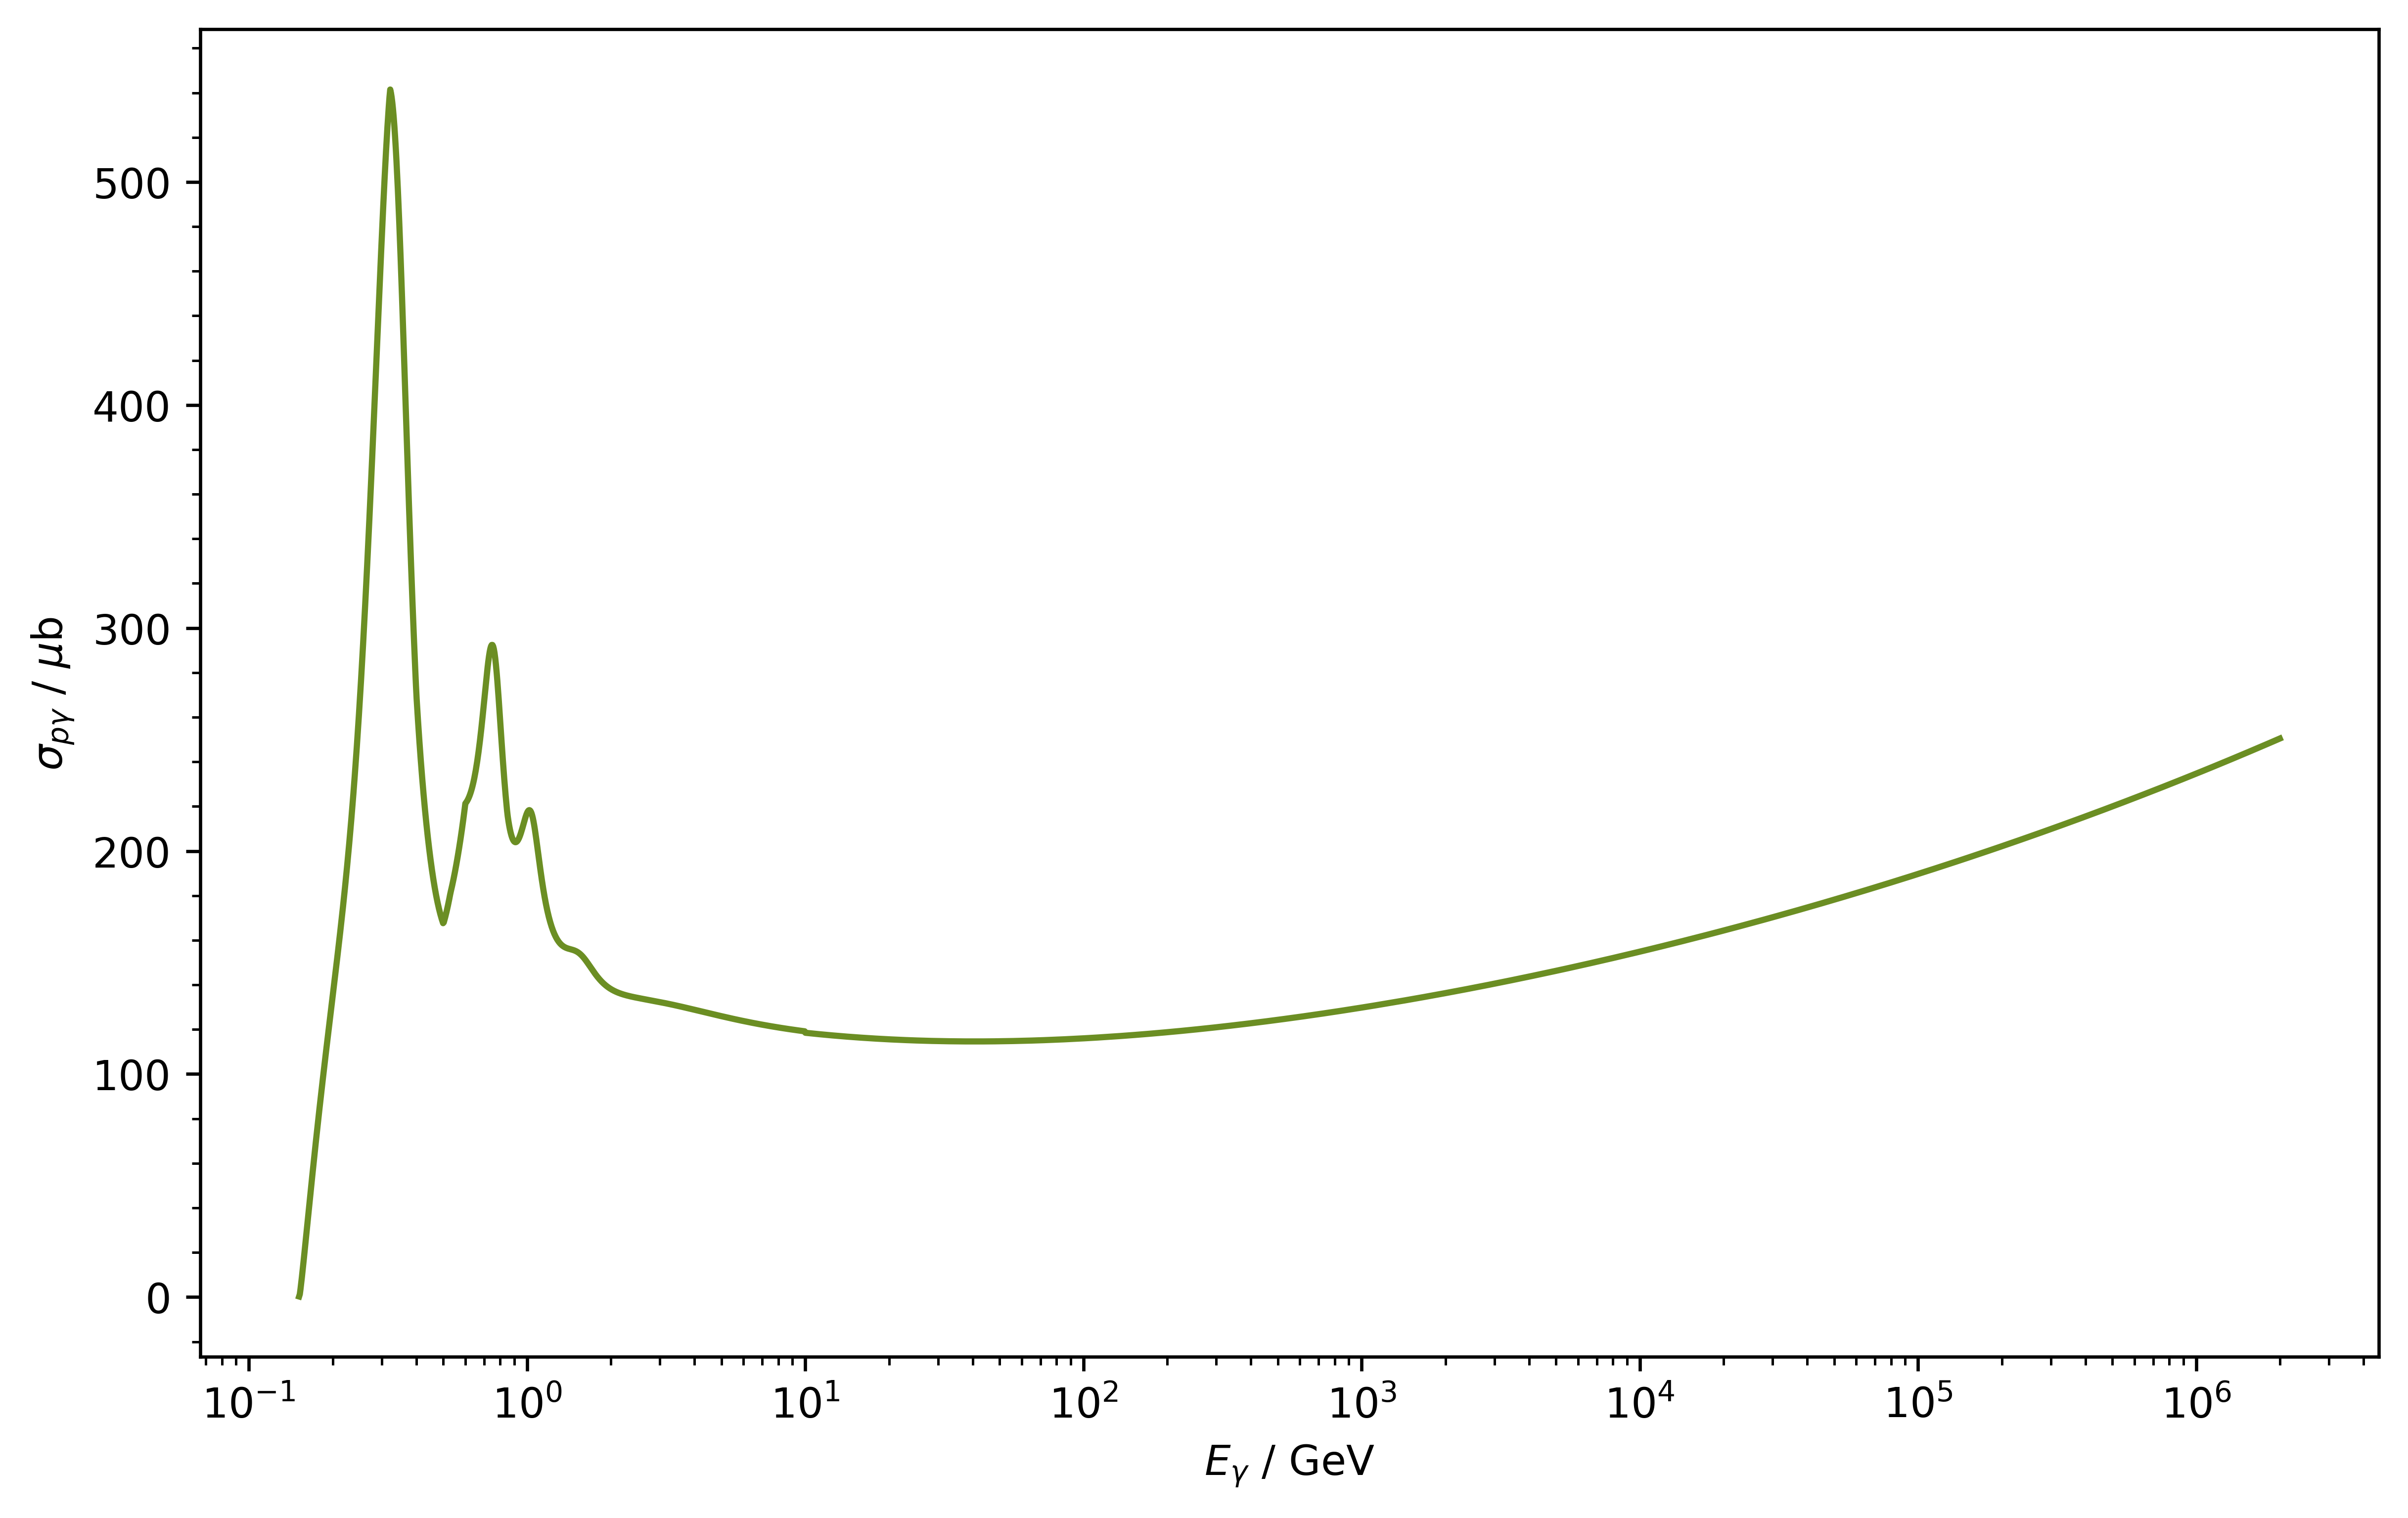

In [16]:
E_gamma, sig = np.genfromtxt('xs_proton_data.txt', unpack=True)

plt.plot(E_gamma)

plt.yscale('log')

plt.ylabel(r'$E_\gamma$ / GeV')

plt.show()
plt.close()

print(f'{len(E_gamma):} logarithmically distributed entries')

plt.plot(E_gamma, sig)

plt.xscale('log')

plt.xlabel(r'$E_\gamma$ / GeV')
plt.ylabel(r'$\sigma_{p\gamma}$ / $\mu$b')

plt.show()
plt.close()

#### Active Galactic Nucleus